# Group 12 Guided Project
## 1. Introduction

## 2. Data Collection & Preprocessing

### 2.1 Data Collection

#### 2.1.1 Singapore Traffic Flow API

<p>To get the Singapore traffic flow data, API provided by Land Transpotation DataMall is used: <a>https://datamall2.mytransport.sg/ltaodataservice/TrafficFlow</a></p>

<p>Below code is used to call the API and get the provided data, which only include the daily peak hours (7-9am) traffic volume with location details in Feb 2024.</p>

<p>Details of traffic_flow_sg dataset: <b>average traffic volume per hour from 7-9 AM everyday in Feb 2024</b>.</p>

In [125]:
import requests
import pandas as pd

# url to call the api which will return the file link
url_get_traffic_flow_link = "https://datamall2.mytransport.sg/ltaodataservice/TrafficFlow"
apiKey = 'dZMBPqIXQrenFv/Qte43bw=='

# payload = {}
headers = {
  'AccountKey': apiKey,
  'accept': 'application/json'
}

api_response = requests.get(url_get_traffic_flow_link, headers=headers)
json_link = api_response.json()
url_data = pd.json_normalize(
        data=json_link,
        record_path='value',
        errors='ignore',
        sep ='.'
    )
# to get file link from returned result, which will expire after 5 mins
url_traffic_flow = url_data['Link'][0]

# to get the actual data via file link
link_response = requests.get(url_traffic_flow, headers=headers, timeout=(5, 15))
json_data = link_response.json()
traffic_flow_sg = pd.json_normalize(
            data=json_data,
            record_path='Value',
            meta=[
                'LastUpdatedDate'
            ],
            errors='ignore',
            sep ='.'
        )
# check the traffic flow data
traffic_flow_sg

,LinkID,Date,HourOfDate,Volume,StartLon,StartLat,EndLon,EndLat,RoadName,RoadCat,LastUpdatedDate
0,103000122,01/02/2024,7,3881,103.694408899999999,1.350438528000000,103.6953675,1.351780186,PAN ISLAND EXPRESSWAY,CAT1,2024-05-31
1,103000122,01/02/2024,8,4644,103.694408899999999,1.350438528000000,103.6953675,1.351780186,PAN ISLAND EXPRESSWAY,CAT1,2024-05-31
2,103000122,02/02/2024,7,4056,103.694408899999999,1.350438528000000,103.6953675,1.351780186,PAN ISLAND EXPRESSWAY,CAT1,2024-05-31
3,103000122,02/02/2024,8,4594,103.694408899999999,1.350438528000000,103.6953675,1.351780186,PAN ISLAND EXPRESSWAY,CAT1,2024-05-31
4,103000122,03/02/2024,7,2687,103.694408899999999,1.350438528000000,103.6953675,1.351780186,PAN ISLAND EXPRESSWAY,CAT1,2024-05-31
...,...,...,...,...,...,...,...,...,...,...,...
75496,118001452,27/02/2024,8,2629,103.702939700000002,1.361370100000000,103.7035447,1.362128061,KRANJI EXPRESSWAY,CAT1,2024-05-31
75497,118001452,28/02/2024,7,2171,103.702939700000002,1.361370100000000,103.7035447,1.362128061,KRANJI EXPRESSWAY,CAT1,2024-05-31
75498,118001452,28/02/2024,8,2510,103.702939700000002,1.361370100000000,103.7035447,1.362128061,KRANJI EXPRESSWAY,CAT1,2024-05-31
75499,118001452,29/02/2024,7,2204,103.702939700000002,1.361370100000000,103.7035447,1.362128061,KRANJI EXPRESSWAY,CAT1,2024-05-31


#### 2.1.2 Singapore Traffic Speed Bands API

<p>To get the Singapore traffic speed bands data, API provided by Land Transpotation DataMall is used: <a>https://datamall2.mytransport.sg/ltaodataservice/v3/TrafficSpeedBands</a></p>

<p>This API will return the current traffic speeds on expressways and arterial roads, each time will only return 500 records.</p>

<p>Details of traffic_speed_bands_sg: current traffic speeds data will return if call again, <b>data used for analysis in this project <i>traffic_speed_bands_sg.csv</i> is data updated at 2024-10-03 21:25:00<b>.</p>

In [126]:
traffic_speed_bands_sg = pd.read_csv('traffic_speed_bands_sg.csv')
traffic_speed_bands_sg

,LinkID,RoadName,RoadCategory,SpeedBand,MinimumSpeed,MaximumSpeed,StartLon,StartLat,EndLon,EndLat,odata.metadata,lastUpdatedTime
0,103000000,KENT ROAD,E,4,30.0,39.0,103.852981,1.317014,103.852599,1.316684,http://datamall2.mytransport.sg/ltaodataservic...,2024-10-03 21:25:00
1,103000010,BUCKLEY ROAD,E,2,10.0,19.0,103.841023,1.316651,103.840226,1.316912,http://datamall2.mytransport.sg/ltaodataservic...,2024-10-03 21:25:00
2,103000011,BUCKLEY ROAD,E,2,10.0,19.0,103.840226,1.316912,103.841023,1.316651,http://datamall2.mytransport.sg/ltaodataservic...,2024-10-03 21:25:00
3,103000014,SHREWSBURY ROAD,E,4,30.0,39.0,103.847003,1.318673,103.847114,1.318021,http://datamall2.mytransport.sg/ltaodataservic...,2024-10-03 21:25:00
4,103000015,SHREWSBURY ROAD,E,4,30.0,39.0,103.847114,1.318021,103.847003,1.318673,http://datamall2.mytransport.sg/ltaodataservic...,2024-10-03 21:25:00
...,...,...,...,...,...,...,...,...,...,...,...,...
59001,117000671,WOODLANDS SECTOR 2,C,2,10.0,19.0,103.809292,1.460595,103.809924,1.460907,http://datamall2.mytransport.sg/ltaodataservic...,2024-10-03 21:25:00
59002,117000674,WOODLANDS AVENUE 10,C,6,50.0,59.0,103.810270,1.461077,103.810433,1.460750,http://datamall2.mytransport.sg/ltaodataservic...,2024-10-03 21:25:00
59003,117000675,WOODLANDS AVENUE 10,C,4,30.0,39.0,103.810270,1.461077,103.810125,1.461361,http://datamall2.mytransport.sg/ltaodataservic...,2024-10-03 21:25:00
59004,117000678,WOODLANDS AVENUE 10,C,5,40.0,49.0,103.810125,1.461361,103.810270,1.461077,http://datamall2.mytransport.sg/ltaodataservic...,2024-10-03 21:25:00


<b>DO NOT RUN Again, as this will return the current data.</b>
<p>The code below is to get all current traffic speed bands data, convert to panda frame format and save as .csv file (time: 2024-10-03 21:25:00) for further analysis.</p>

In [127]:
# url_speed_bands = "https://datamall2.mytransport.sg/ltaodataservice/v3/TrafficSpeedBands?$skip={}"
# apiKey = 'y4MnOaz/QmCC6O/5aUOa9A=='
# headers = {
#     'AccountKey': apiKey,
#     'accept': 'application/json'
# }

# records_per_call = 500  # each call will return 500 records
# data_list = []

# skip = 0

# while True:
#     url = url_speed_bands.format(skip)
#     response = requests.get(url, headers=headers)
    
#     if response.status_code == 200:
#         json_data = response.json()
#         if not json_data:
#             break

#         df_data = pd.json_normalize(
#             data=json_data,
#             record_path='value',
#             meta=[
#                 'odata.metadata',
#                 'lastUpdatedTime'
#             ],
#             errors='ignore',
#             sep='.'
#         )

#         data_list.append(df_data)
        
#         # if returned data is less than 500, then stop the while loop
#         if len(json_data['value']) < records_per_call:
#             break

#         skip += records_per_call
#     else:
#         print(f"Failed to fetch data from skip {skip}")
#         break

# # combine all data together
# traffic_speed_bands_sg = pd.concat(data_list, ignore_index=False)
# # save as .csv file for further analysis
# traffic_speed_bands_sg.to_csv('traffic_speed_bands_sg.csv', index=False)

#### 2.1.3 Singapore Pollutant Standards Index (PSI) API 
<p>To get the accurate Pollutant Standards Index (PSI) data, API provided by NEA (National Environment Agency) in SG Gov Data Website is used: <a>https://data.gov.sg/datasets/d_fe37906a0182569d891506e815e819b7/view</a></p>
<p>Below code enables users to input the date they want to check the PSI data, making it easy to get the PSI data for any specific date range. This makes the code clearer and more reusable.</p>

In [128]:
import requests
import pandas as pd
import time
#import backoff

class RateLimitError(Exception):
    pass

# create a function to call API with exception handling and retries
# @backoff.on_exception(backoff.expo, RateLimitError)
def call_API(url, retries = 3, delay = 1):
    for retry in range(retries):
        try:
            api_response = requests.get(url)
            api_response.raise_for_status()
            api_response_json = api_response.json()  
            return api_response_json 
        except requests.RequestException as e:
            print(f"Attempt {retry + 1} failed due to: {e}")
            if retry < retries - 1: 
                time.sleep(delay)  
            else:
                print("Retried for three times, now give up")
                return None

In [129]:
from datetime import datetime, timedelta

# get PSI data for given date
def get_psi_data_for_date(date):
    url = f"https://api-open.data.gov.sg/v2/real-time/api/psi?date={date}"
    data = call_API(url)
    if 'data' in data and 'items' in data['data'] and len(data['data']['items']) > 0:
        psi_readings = data['data']['items'][0]
        region_metadata = data['data']['regionMetadata']
        return psi_readings, region_metadata

# retrieve PSI data for target date
def get_psi_data_for_Feb_data():
    
    # give time range date
    start_date = datetime(2024, 2, 1)
    end_date = datetime(2024, 2, 29)
    
    all_psi_data = []
    all_region_data = []
    
    # get the data from 2024-02-01 to 2024-02-29
    current_date = start_date
    while current_date <= end_date:
        for hour in [7, 8]:
            date_str = current_date.strftime(f'%Y-%m-%dT{hour:02d}:00:00')
            psi_readings, region_metadata = get_psi_data_for_date(date_str)
            timestamp_str = psi_readings['timestamp']
            timestamp = datetime.strptime(timestamp_str, "%Y-%m-%dT%H:%M:%S%z")
            date_str = timestamp.date().isoformat()
            hour_of_date = timestamp.hour
            if psi_readings and region_metadata:
                for key, region_data in psi_readings['readings'].items():
                    for region, reading_value in region_data.items():
                        all_psi_data.append({
                            'region': region,
                            'date': date_str,
                            'timestamp': timestamp_str,
                            'hourOfDate': hour_of_date,
                            'reading_type': key,  
                            'reading_value': reading_value
                        })
                for region in region_metadata:
                    all_region_data.append({
                        'region': region['name'],
                        'latitude': region['labelLocation']['latitude'],
                        'longitude': region['labelLocation']['longitude']
                    })
        current_date += timedelta(days=1)
    
     # psi data df
    all_psi_sg = pd.DataFrame(all_psi_data)
    
    # region location data df
    all_region_sg = pd.DataFrame(all_region_data)
    
    return all_psi_sg, all_region_sg


def get_psi_data_for_single_date():
    
    # give single date
    single_date = "2024-10-03T21:25:00"
    
    single_psi_data = []
    single_region_data = []
    
    # get the single date data
    psi_readings, region_metadata = get_psi_data_for_date(single_date)
    if psi_readings and region_metadata:
        # store single_region_data
        for region in region_metadata:
            single_region_data.append({
                'region': region['name'],
                'latitude': region['labelLocation']['latitude'],
                'longitude': region['labelLocation']['longitude']
            })
        # store single_psi_readings
        timestamp_str = psi_readings['timestamp']
        timestamp = datetime.strptime(timestamp_str, "%Y-%m-%dT%H:%M:%S%z")
        date_str = timestamp.date().isoformat()
        hour_of_date = timestamp.hour
        for key, reading_data in psi_readings['readings'].items():
            for region, reading_value in reading_data.items():
                single_psi_data.append({
                    'region': region,
                    'date': date_str,
                    'timestamp': timestamp_str,
                    'hourOfDate': hour_of_date,
                    'reading_type': key,  
                    'reading_value': reading_value
                })
    
    # single psi data df
    single_psi_sg = pd.DataFrame(single_psi_data)
    
     # single psi data df
    single_region_sg = pd.DataFrame(single_region_data)
    
    return single_psi_sg, single_region_sg

In [130]:
all_psi_sg, all_region_sg = get_psi_data_for_Feb_data()

In [131]:
all_psi_sg

,region,date,timestamp,hourOfDate,reading_type,reading_value
0,west,2024-02-01,2024-02-01T07:00:00+08:00,7,o3_sub_index,9
1,east,2024-02-01,2024-02-01T07:00:00+08:00,7,o3_sub_index,6
2,central,2024-02-01,2024-02-01T07:00:00+08:00,7,o3_sub_index,8
3,south,2024-02-01,2024-02-01T07:00:00+08:00,7,o3_sub_index,7
4,north,2024-02-01,2024-02-01T07:00:00+08:00,7,o3_sub_index,10
...,...,...,...,...,...,...
3475,west,2024-02-29,2024-02-29T08:00:00+08:00,8,co_sub_index,3
3476,east,2024-02-29,2024-02-29T08:00:00+08:00,8,co_sub_index,4
3477,central,2024-02-29,2024-02-29T08:00:00+08:00,8,co_sub_index,6
3478,south,2024-02-29,2024-02-29T08:00:00+08:00,8,co_sub_index,3


In [132]:
all_region_sg

,region,latitude,longitude
0,west,1.35735,103.70
1,east,1.35735,103.94
2,central,1.35735,103.82
3,south,1.29587,103.82
4,north,1.41803,103.82
...,...,...,...
285,west,1.35735,103.70
286,east,1.35735,103.94
287,central,1.35735,103.82
288,south,1.29587,103.82


In [133]:
single_psi_sg, single_region_sg = get_psi_data_for_single_date()
single_psi_sg.to_csv('single_psi_sg.csv', index=False)

In [134]:
single_psi_sg

,region,date,timestamp,hourOfDate,reading_type,reading_value
0,west,2024-10-03,2024-10-03T21:00:00+08:00,21,o3_sub_index,6
1,east,2024-10-03,2024-10-03T21:00:00+08:00,21,o3_sub_index,8
2,central,2024-10-03,2024-10-03T21:00:00+08:00,21,o3_sub_index,11
3,south,2024-10-03,2024-10-03T21:00:00+08:00,21,o3_sub_index,4
4,north,2024-10-03,2024-10-03T21:00:00+08:00,21,o3_sub_index,7
5,west,2024-10-03,2024-10-03T21:00:00+08:00,21,no2_one_hour_max,28
6,east,2024-10-03,2024-10-03T21:00:00+08:00,21,no2_one_hour_max,56
7,central,2024-10-03,2024-10-03T21:00:00+08:00,21,no2_one_hour_max,85
8,south,2024-10-03,2024-10-03T21:00:00+08:00,21,no2_one_hour_max,32
9,north,2024-10-03,2024-10-03T21:00:00+08:00,21,no2_one_hour_max,53


#### 2.1.4 Singapore Monthly Motor Vehicle Population by Vehicle Type Data
<p>To get the Monthly Motor Vehicle Population, data provided by LTA (Land Transport Authority) in SG Gov Data Website is used: <a>https://data.gov.sg/datasets/d_2ecb009f1e1ec5a816a454944dec4022/view </a></p>
<p>The data is downloaded and then inserted to further review and analyze. </p>

In [135]:
import pandas as pd

sg_vehicle_df = pd.read_csv('vehicle_data_sg.csv')
print(sg_vehicle_df.count)

sg_vehicle_df.dropna(inplace=True)
sg_vehicle_df.drop_duplicates(inplace=True)

sg_vehicle_df['month'] = pd.to_datetime(sg_vehicle_df['month'], format='%Y-%m')
sg_vehicle_df['number'] = sg_vehicle_df['number'].astype(int)
sg_vehicle_df['vehicle_type'] = sg_vehicle_df['vehicle_type'].str.strip().str.title()

print(sg_vehicle_df.dtypes)

<bound method DataFrame.count of        month            vehicle_type  number
0    2012-01                    Cars  593555
1    2012-01             Rental cars   13970
2    2012-01                   Taxis   27059
3    2012-01                   Buses   17037
4    2012-01  Goods & other vehicles  159854
..       ...                     ...     ...
907  2024-08       Private Hire Cars   86453
908  2024-08                   Taxis   13352
909  2024-08                   Buses   18573
910  2024-08  Goods & other vehicles  166749
911  2024-08             Motorcycles  146301

[912 rows x 3 columns]>
month           datetime64[ns]
vehicle_type            object
number                   int64
dtype: object


### 2.2 Data Cleaning

#### 2.2.1 Singapore Traffic Flow

<li>Check and clean null value and duplicated values. </li>
<li>Convert the data into correct format.</li>

In [136]:
traffic_flow_sg.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75501 entries, 0 to 75500
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   LinkID           75501 non-null  object
 1   Date             75501 non-null  object
 2   HourOfDate       75501 non-null  object
 3   Volume           75501 non-null  object
 4   StartLon         75501 non-null  object
 5   StartLat         75501 non-null  object
 6   EndLon           75501 non-null  object
 7   EndLat           75501 non-null  object
 8   RoadName         75501 non-null  object
 9   RoadCat          75501 non-null  object
 10  LastUpdatedDate  75501 non-null  object
dtypes: object(11)
memory usage: 6.3+ MB


In [137]:
# Check for missing values
print("Missing values in each column:\n", traffic_flow_sg.isnull().sum())

# Check duplicates
duplicates = traffic_flow_sg.duplicated().sum()
print(f"\nNumber of duplicate rows: {duplicates}")
if duplicates > 0:
    traffic_flow_sg.drop_duplicates(inplace=True)
    
traffic_flow_sg['Date'] = pd.to_datetime(traffic_flow_sg['Date'], format='%d/%m/%Y')
traffic_flow_sg['Volume'] = pd.to_numeric(traffic_flow_sg['Volume'], errors='coerce')

# drop unnecessary data like lastUpdatedTime
traffic_flow_sg.drop(columns=['LastUpdatedDate'], inplace=True)

Missing values in each column:
 LinkID             0
Date               0
HourOfDate         0
Volume             0
StartLon           0
StartLat           0
EndLon             0
EndLat             0
RoadName           0
RoadCat            0
LastUpdatedDate    0
dtype: int64



Number of duplicate rows: 0


#### 2.2.2 Singapore Traffic Speed Bands

<li>Check and clean duplicated values, replace the null value with 0.</li>
<li>Drop unnecessary columns.</li>

In [138]:
traffic_speed_bands_sg.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59006 entries, 0 to 59005
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   LinkID           59006 non-null  int64  
 1   RoadName         59006 non-null  object 
 2   RoadCategory     59006 non-null  object 
 3   SpeedBand        59006 non-null  int64  
 4   MinimumSpeed     59004 non-null  float64
 5   MaximumSpeed     59004 non-null  float64
 6   StartLon         59006 non-null  float64
 7   StartLat         59006 non-null  float64
 8   EndLon           59006 non-null  float64
 9   EndLat           59006 non-null  float64
 10  odata.metadata   59006 non-null  object 
 11  lastUpdatedTime  59006 non-null  object 
dtypes: float64(6), int64(2), object(4)
memory usage: 5.4+ MB


In [139]:
# Check for missing values
print("Missing values in each column:\n", traffic_speed_bands_sg.isnull().sum())
# fill the missing value in MinimumSpeed and MaximumSpeed columns with value 0
traffic_speed_bands_sg['MinimumSpeed'].fillna(0, inplace=True)
traffic_speed_bands_sg['MaximumSpeed'].fillna(0, inplace=True)
# Check for missing values again
print("\nMissing values in each column:\n", traffic_speed_bands_sg.isnull().sum())

# Check duplicates
duplicates = traffic_speed_bands_sg.duplicated().sum()
print(f"\nNumber of duplicate rows: {duplicates}")
if duplicates > 0:
    traffic_speed_bands_sg.drop_duplicates(inplace=True)

# drop unnecessary data like lastUpdatedTime and odata.metadata
traffic_speed_bands_sg.drop(columns=['lastUpdatedTime', 'odata.metadata'], inplace=True)


Missing values in each column:
 LinkID             0
RoadName           0
RoadCategory       0
SpeedBand          0
MinimumSpeed       2
MaximumSpeed       2
StartLon           0
StartLat           0
EndLon             0
EndLat             0
odata.metadata     0
lastUpdatedTime    0
dtype: int64

Missing values in each column:
 LinkID             0
RoadName           0
RoadCategory       0
SpeedBand          0
MinimumSpeed       0
MaximumSpeed       0
StartLon           0
StartLat           0
EndLon             0
EndLat             0
odata.metadata     0
lastUpdatedTime    0
dtype: int64

Number of duplicate rows: 0


/var/folders/fg/pr9xmsbj4kb4pxfl91jb5d3h0000gn/T/ipykernel_28409/3900335754.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  traffic_speed_bands_sg['MinimumSpeed'].fillna(0, inplace=True)
/var/folders/fg/pr9xmsbj4kb4pxfl91jb5d3h0000gn/T/ipykernel_28409/3900335754.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setti

In [140]:
traffic_speed_bands_sg

,LinkID,RoadName,RoadCategory,SpeedBand,MinimumSpeed,MaximumSpeed,StartLon,StartLat,EndLon,EndLat
0,103000000,KENT ROAD,E,4,30.0,39.0,103.852981,1.317014,103.852599,1.316684
1,103000010,BUCKLEY ROAD,E,2,10.0,19.0,103.841023,1.316651,103.840226,1.316912
2,103000011,BUCKLEY ROAD,E,2,10.0,19.0,103.840226,1.316912,103.841023,1.316651
3,103000014,SHREWSBURY ROAD,E,4,30.0,39.0,103.847003,1.318673,103.847114,1.318021
4,103000015,SHREWSBURY ROAD,E,4,30.0,39.0,103.847114,1.318021,103.847003,1.318673
...,...,...,...,...,...,...,...,...,...,...
59001,117000671,WOODLANDS SECTOR 2,C,2,10.0,19.0,103.809292,1.460595,103.809924,1.460907
59002,117000674,WOODLANDS AVENUE 10,C,6,50.0,59.0,103.810270,1.461077,103.810433,1.460750
59003,117000675,WOODLANDS AVENUE 10,C,4,30.0,39.0,103.810270,1.461077,103.810125,1.461361
59004,117000678,WOODLANDS AVENUE 10,C,5,40.0,49.0,103.810125,1.461361,103.810270,1.461077


#### 2.2.3 Singapore Pollutant Standard Index - single timestamp

<li>Check and clean null value and duplicated values. </li>
<li>Convert the data into correct format.</li>
<li>Drop unnecessary column.</li>

In [141]:
single_psi_sg.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60 entries, 0 to 59
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   region         60 non-null     object
 1   date           60 non-null     object
 2   timestamp      60 non-null     object
 3   hourOfDate     60 non-null     int64 
 4   reading_type   60 non-null     object
 5   reading_value  60 non-null     int64 
dtypes: int64(2), object(4)
memory usage: 2.9+ KB


In [142]:
# clean the specific time data, single_psi_sg
# Check for missing values
print("Missing values in each column:\n", single_psi_sg.isnull().sum())

single_psi_sg.dropna(subset=['reading_value'], inplace=True)

# Check duplicates
duplicates = single_psi_sg.duplicated().sum()
print(f"Number of duplicate rows: {duplicates}")
if duplicates > 0:
    single_psi_sg.drop_duplicates(inplace=True)

single_psi_sg['date'] = pd.to_datetime(single_psi_sg['date'])
single_psi_sg['reading_value'] = pd.to_numeric(single_psi_sg['reading_value'], errors='coerce')

# drop unnecessary data like lastUpdatedTime and odata.metadata
single_psi_sg.drop(columns=['timestamp'], inplace=True)

Missing values in each column:
 region           0
date             0
timestamp        0
hourOfDate       0
reading_type     0
reading_value    0
dtype: int64
Number of duplicate rows: 0


In [143]:
# Count unique reading types for single_psi_sg
unique_reading_types = single_psi_sg['reading_type'].unique()
print(f"reading types: {unique_reading_types}")

reading types: ['o3_sub_index' 'no2_one_hour_max' 'o3_eight_hour_max'
 'psi_twenty_four_hourly' 'pm10_twenty_four_hourly' 'pm10_sub_index'
 'pm25_twenty_four_hourly' 'so2_sub_index' 'pm25_sub_index'
 'so2_twenty_four_hourly' 'co_eight_hour_max' 'co_sub_index']


#### 2.2.4 Singapore Pollutant Standard Index - Feb PSI data and Region data

<li>Check and clean null value and duplicated values. </li>
<li>Convert the data into correct format.</li>
<li>Drop unnecessary column.</li>


In [144]:
# clean the Feb data, all_psi_sg
# Check for missing values
print("Missing values in each column:\n", all_psi_sg.isnull().sum())

all_psi_sg.dropna(subset=['reading_value'], inplace=True)

# Check duplicates
duplicates = all_psi_sg.duplicated().sum()
print(f"Number of duplicate rows: {duplicates}")
if duplicates > 0:
    all_psi_sg.drop_duplicates(inplace=True)

all_psi_sg['date'] = pd.to_datetime(all_psi_sg['date'])
all_psi_sg['reading_value'] = pd.to_numeric(all_psi_sg['reading_value'], errors='coerce')

# drop unnecessary data like timestamp
all_psi_sg.drop(columns=['timestamp'], inplace=True)
print(all_psi_sg.info())

Missing values in each column:
 region           0
date             0
timestamp        0
hourOfDate       0
reading_type     0
reading_value    0
dtype: int64
Number of duplicate rows: 60
<class 'pandas.core.frame.DataFrame'>
Index: 3420 entries, 0 to 3479
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   region         3420 non-null   object        
 1   date           3420 non-null   datetime64[ns]
 2   hourOfDate     3420 non-null   int64         
 3   reading_type   3420 non-null   object        
 4   reading_value  3420 non-null   int64         
dtypes: datetime64[ns](1), int64(2), object(2)
memory usage: 160.3+ KB
None


In [145]:
# Count unique reading types for all_psi_sg
unique_reading_types = all_psi_sg['reading_type'].unique()
print(f"reading types: {unique_reading_types}")

reading types: ['o3_sub_index' 'no2_one_hour_max' 'o3_eight_hour_max'
 'psi_twenty_four_hourly' 'pm10_twenty_four_hourly' 'pm10_sub_index'
 'pm25_twenty_four_hourly' 'so2_sub_index' 'pm25_sub_index'
 'so2_twenty_four_hourly' 'co_eight_hour_max' 'co_sub_index']


<li>all_region_sg dataset</li>

In [146]:
# clean the Feb data, all_region_sg
# Check for missing values
print("Missing values in each column:\n", all_region_sg.isnull().sum())

all_region_sg.dropna(inplace=True)

# Check duplicates
duplicates = all_region_sg.duplicated().sum()
print(f"Number of duplicate rows: {duplicates}")
if duplicates > 0:
    all_region_sg.drop_duplicates(inplace=True)

print(all_region_sg.info())

Missing values in each column:
 region       0
latitude     0
longitude    0
dtype: int64
Number of duplicate rows: 285
<class 'pandas.core.frame.DataFrame'>
Index: 5 entries, 0 to 4
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   region     5 non-null      object 
 1   latitude   5 non-null      float64
 2   longitude  5 non-null      float64
dtypes: float64(2), object(1)
memory usage: 160.0+ bytes
None


In [147]:
all_region_sg

,region,latitude,longitude
0,west,1.35735,103.70
1,east,1.35735,103.94
2,central,1.35735,103.82
3,south,1.29587,103.82
4,north,1.41803,103.82


### 2.3 Data Preprocessing

#### 2.3.1 Normalize the SpeedBand and air pollutants data by region and by pollutant types

In [148]:
# round the data for latitude and longitude
traffic_speed_bands_sg['StartLon'] = traffic_speed_bands_sg['StartLon'].round(2)
traffic_speed_bands_sg['StartLat'] = traffic_speed_bands_sg['StartLat'].round(2)
traffic_speed_bands_sg['EndLon'] = traffic_speed_bands_sg['EndLon'].round(2)
traffic_speed_bands_sg['EndLat'] = traffic_speed_bands_sg['EndLat'].round(2)

# use KDTree method to get the region information for traffic_speed_bands_sg based on all_region_sg
import scipy
from scipy.spatial import cKDTree
import numpy as np

tree = cKDTree(all_region_sg[['latitude', 'longitude']].values)
distances, indices = tree.query(traffic_speed_bands_sg[['StartLat', 'StartLon']].values)
traffic_speed_bands_sg['region'] = all_region_sg.iloc[indices]['region'].values

In [149]:
# calculate the sum of speedband value with group by "region"
region_speedband_sum = traffic_speed_bands_sg.groupby('region')['SpeedBand'].sum().reset_index()
# calculate the average reading values by regin and by type
region_pollutant_avg = single_psi_sg.groupby(['region', 'reading_type'])['reading_value'].mean().unstack().reset_index()
merged_data = pd.merge(region_speedband_sum, region_pollutant_avg, on='region')
print("DataFrame before Min-Max Scaling (Normalization):")
print(merged_data.to_string(index=False))

from sklearn.preprocessing import MinMaxScaler
min_max_scaler = MinMaxScaler()
normalized_data = min_max_scaler.fit_transform(merged_data[['SpeedBand', 'co_eight_hour_max', 'co_sub_index', 'no2_one_hour_max', 'o3_eight_hour_max', 'o3_sub_index', 'pm10_sub_index', 'pm10_twenty_four_hourly', 'pm25_sub_index', 'pm25_twenty_four_hourly', 'psi_twenty_four_hourly', 'so2_sub_index', 'so2_twenty_four_hourly']])
normalized_merge_data = merged_data
normalized_merge_data[['SpeedBand', 'co_eight_hour_max', 'co_sub_index', 'no2_one_hour_max', 'o3_eight_hour_max', 'o3_sub_index', 'pm10_sub_index', 'pm10_twenty_four_hourly', 'pm25_sub_index', 'pm25_twenty_four_hourly', 'psi_twenty_four_hourly', 'so2_sub_index', 'so2_twenty_four_hourly']] = pd.DataFrame(normalized_data)
print("DataFrame after Min-Max Scaling (Normalization):")
print(normalized_merge_data.to_string(index=False))

DataFrame before Min-Max Scaling (Normalization):
 region  SpeedBand  co_eight_hour_max  co_sub_index  no2_one_hour_max  o3_eight_hour_max  o3_sub_index  pm10_sub_index  pm10_twenty_four_hourly  pm25_sub_index  pm25_twenty_four_hourly  psi_twenty_four_hourly  so2_sub_index  so2_twenty_four_hourly
central      45486                0.0           4.0              85.0               25.0          11.0            26.0                     26.0            46.0                     11.0                    46.0            2.0                     3.0
   east      67467                1.0           6.0              56.0               18.0           8.0            19.0                     19.0            36.0                      9.0                    36.0            2.0                     3.0
  north      36048                0.0           4.0              53.0               17.0           7.0            19.0                     19.0            40.0                     10.0                    40

In [150]:
# calculate the normalized_congestion = 1-SpeedBand
normalized_merge_data['normalized_congestion'] = 1-normalized_merge_data['SpeedBand']
normalized_merge_data

,region,SpeedBand,co_eight_hour_max,co_sub_index,no2_one_hour_max,o3_eight_hour_max,o3_sub_index,pm10_sub_index,pm10_twenty_four_hourly,pm25_sub_index,pm25_twenty_four_hourly,psi_twenty_four_hourly,so2_sub_index,so2_twenty_four_hourly,normalized_congestion
0,central,0.300391,0.0,0.333333,1.000000,1.000000,1.000000,1.0,1.0,0.625,0.50,0.625,0.333333,0.2,0.699609
1,east,1.000000,1.0,1.000000,0.491228,0.533333,0.571429,0.3,0.3,0.000,0.00,0.000,0.333333,0.2,0.000000
2,north,0.000000,0.0,0.333333,0.438596,0.466667,0.428571,0.3,0.3,0.250,0.25,0.250,0.000000,0.0,1.000000
3,south,0.784939,0.0,0.000000,0.070175,0.000000,0.000000,0.0,0.0,0.000,0.00,0.000,0.333333,0.2,0.215061
4,west,0.369585,0.0,0.333333,0.000000,0.200000,0.285714,0.6,0.6,1.000,1.00,1.000,1.000000,1.0,0.630415


#### 2.3.2 Calculate the average traffic volume and PSI values for daily peak hours in Feb 2024

<li>Calculate the average volume for daily peak hours and save as a new dataframe <b><u>"Feb_peakhours_traffic_flow"</u></b> for further analysis.</li>

In [151]:
# round the data for latitude and longitude
traffic_flow_sg['StartLon'] = pd.to_numeric(traffic_flow_sg['StartLon']).round(2) # convert 'object' to 'float' before rounding
traffic_flow_sg['StartLat'] =  pd.to_numeric(traffic_flow_sg['StartLat']).round(2)
traffic_flow_sg['EndLon'] =  pd.to_numeric(traffic_flow_sg['EndLon']).round(2)
traffic_flow_sg['EndLat'] =  pd.to_numeric(traffic_flow_sg['EndLat']).round(2)

# use KDTree method to get the region information for traffic_speed_bands_sg based on all_region_sg
import scipy
from scipy.spatial import cKDTree
import numpy as np

tree = cKDTree(all_region_sg[['latitude', 'longitude']].values)
distances, indices = tree.query(traffic_flow_sg[['StartLat', 'StartLon']].values)
traffic_flow_sg['region'] = all_region_sg.iloc[indices]['region'].values

In [152]:
traffic_flow_sg['avg_volume'] = traffic_flow_sg.groupby(['LinkID', 'Date'])['Volume'].transform('mean')
Feb_peakhours_traffic_flow = traffic_flow_sg.drop(columns=['HourOfDate', 'Volume'])
# Check duplicates
duplicates = Feb_peakhours_traffic_flow.duplicated().sum()
print(f"\nNumber of duplicate rows: {duplicates}")
if duplicates > 0:
    Feb_peakhours_traffic_flow.drop_duplicates(inplace=True)
Feb_peakhours_traffic_flow


Number of duplicate rows: 37726


,LinkID,Date,StartLon,StartLat,EndLon,EndLat,RoadName,RoadCat,region,avg_volume
0,103000122,2024-02-01,103.69,1.35,103.7,1.35,PAN ISLAND EXPRESSWAY,CAT1,west,4262.5
2,103000122,2024-02-02,103.69,1.35,103.7,1.35,PAN ISLAND EXPRESSWAY,CAT1,west,4325.0
4,103000122,2024-02-03,103.69,1.35,103.7,1.35,PAN ISLAND EXPRESSWAY,CAT1,west,3062.0
6,103000122,2024-02-04,103.69,1.35,103.7,1.35,PAN ISLAND EXPRESSWAY,CAT1,west,1780.5
8,103000122,2024-02-05,103.69,1.35,103.7,1.35,PAN ISLAND EXPRESSWAY,CAT1,west,2477.5
...,...,...,...,...,...,...,...,...,...,...
75491,118001452,2024-02-25,103.70,1.36,103.7,1.36,KRANJI EXPRESSWAY,CAT1,west,1088.0
75493,118001452,2024-02-26,103.70,1.36,103.7,1.36,KRANJI EXPRESSWAY,CAT1,west,2281.5
75495,118001452,2024-02-27,103.70,1.36,103.7,1.36,KRANJI EXPRESSWAY,CAT1,west,2431.0
75497,118001452,2024-02-28,103.70,1.36,103.7,1.36,KRANJI EXPRESSWAY,CAT1,west,2340.5


<li>Calculate the average reading values for Feb daily peak hours and save as a new dataframe <b><u>"Feb_avg_psi_sg"</u></b> for further analysis.</li>

In [153]:
all_psi_sg['avg_reading_value'] = all_psi_sg.groupby(['region', 'date', 'reading_type'])['reading_value'].transform('mean')
Feb_avg_psi_sg = all_psi_sg.drop(columns=['hourOfDate', 'reading_value'])
print("Missing values in each column:\n", Feb_avg_psi_sg.isnull().sum())
# Check duplicates
duplicates = all_region_sg.duplicated().sum()
print(f"Number of duplicate rows: {duplicates}")

Feb_avg_psi_sg

Missing values in each column:
 region               0
date                 0
reading_type         0
avg_reading_value    0
dtype: int64
Number of duplicate rows: 0


,region,date,reading_type,avg_reading_value
0,west,2024-02-01,o3_sub_index,9.0
1,east,2024-02-01,o3_sub_index,6.0
2,central,2024-02-01,o3_sub_index,7.5
3,south,2024-02-01,o3_sub_index,7.0
4,north,2024-02-01,o3_sub_index,10.0
...,...,...,...,...
3475,west,2024-02-29,co_sub_index,3.0
3476,east,2024-02-29,co_sub_index,4.0
3477,central,2024-02-29,co_sub_index,6.0
3478,south,2024-02-29,co_sub_index,3.0


## 3. Exploratory Data Analysis (EDA)

### 3.1 Correlation Between Congestion Level and Different Air Pollutants

<p>calculate the correlation between congestion level and different air pollutants, to find the most correlated air pollutants for more analysis.</p>
<p><b>Findings</b>: congestion level is mostly positive related to <b><u>pm2.5</u></b> and <b>p<u>m10</u></b>, also the <b><u>PSI value</u></b>. Hence, onwards we will use PSI to do more analysis.</p>

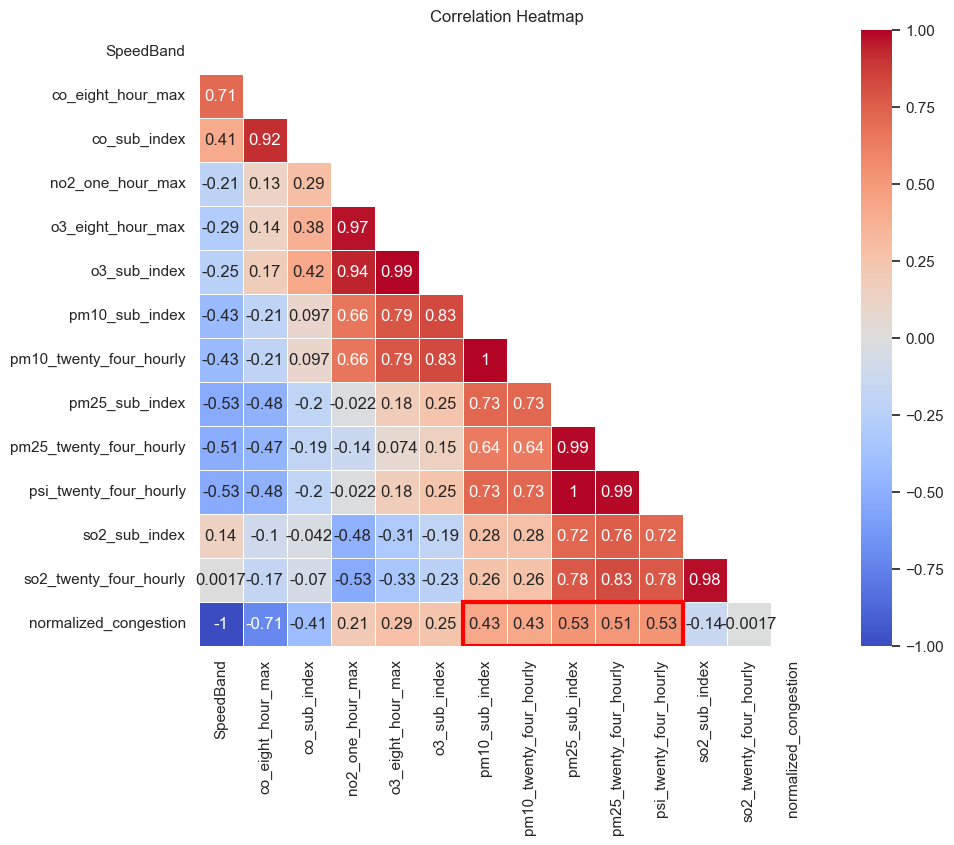

In [154]:
# calculate the correlation between congestion level and different air pollutants, to find the most correlated air pollutants for more analysis
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Rectangle

correlation_matrix = normalized_merge_data.drop(columns=['region']).corr()
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
sns.set(style="white")
plt.figure(figsize=(12, 8))
heatmap = sns.heatmap(correlation_matrix, mask=mask, annot=True, cmap='coolwarm', vmin=-1, vmax=1, square=True, linewidths=.5)
rect = Rectangle((6, 13), 5, 1, fill=False, edgecolor='red', linewidth=3)
heatmap.add_patch(rect)
plt.title('Correlation Heatmap')
plt.show()


### 3.2 Plot the congestion and PSI map  in Singapore - TBD

In [155]:
filtered_single_psi_sg = single_psi_sg[single_psi_sg['reading_type'] == 'pm25_sub_index']
filtered_single_psi_sg = pd.merge(filtered_single_psi_sg, all_region_sg, on='region', how='left')
filtered_single_psi_sg

,region,date,hourOfDate,reading_type,reading_value,latitude,longitude
0,west,2024-10-03,21,pm25_sub_index,52,1.35735,103.70
1,east,2024-10-03,21,pm25_sub_index,36,1.35735,103.94
2,central,2024-10-03,21,pm25_sub_index,46,1.35735,103.82
3,south,2024-10-03,21,pm25_sub_index,36,1.29587,103.82
4,north,2024-10-03,21,pm25_sub_index,40,1.41803,103.82


In [156]:
# import folium
# import osmnx as ox
# import geopandas as gpd

# place_name = "Singapore"

# graph = ox.graph_from_place(place_name, network_type='drive')
# nodes, edges = ox.graph_to_gdfs(graph)

# edges['name'] = edges['name'].str.lower()
# traffic_speed_bands_sg['RoadName'] = traffic_speed_bands_sg['RoadName'].str.lower()

# merged_traffic_data = pd.merge(traffic_speed_bands_sg, edges, left_on='RoadName', right_on='name', how='left')

# map_sg = folium.Map(location=[1.3521, 103.8198], zoom_start=12)

# for _, row in merged_traffic_data.iterrows():
#     if pd.notna(row['geometry']):
#         speed_band = row['SpeedBand']
#         if speed_band == 8:
#             continue
#         color_intensity = int(255 * (8 - speed_band) / 7)
#         color = (255, color_intensity, color_intensity)
#         color_hex = '#{:02x}{:02x}{:02x}'.format(*color)
        
#         folium.PolyLine(
#             locations=[(row['StartLat'], row['StartLon']), (row['EndLat'], row['EndLon'])],
#             color=color_hex,
#             weight=5,
#             opacity=0.7
#         ).add_to(map_sg)
# # map_sg.save('singapore_traffic_speed_map.html')


In [157]:
%pip install folium

Note: you may need to restart the kernel to use updated packages.


In [158]:
import folium
from folium.plugins import FastMarkerCluster
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

map_sg_1 = folium.Map(location=[1.3521, 103.8198], zoom_start=12)

marker_cluster = FastMarkerCluster([]).add_to(map_sg_1)
norm = mcolors.Normalize(vmin=filtered_single_psi_sg['reading_value'].min(), vmax=filtered_single_psi_sg['reading_value'].max())
cmap = plt.get_cmap('Oranges')

for _, row in filtered_single_psi_sg.iterrows():
    pm25 = row['reading_value']
    color = cmap(norm(pm25))
    color_hex = mcolors.to_hex(color)
    if row['region'] in ['east', 'west']:
        radius = 200 
    else:
        radius = 90 
    
    folium.CircleMarker(
        location=[row['latitude'], row['longitude']],
        radius=radius,
        color=color_hex,
        fill=True,
        fill_color=color_hex,
        fill_opacity=0.6,
        popup=f"Region: {row['region']}\nPM2.5: {pm25}"
    ).add_to(map_sg_1)

In [159]:
map_sg_1

### 3.3 Average PSI Reading Values by Region

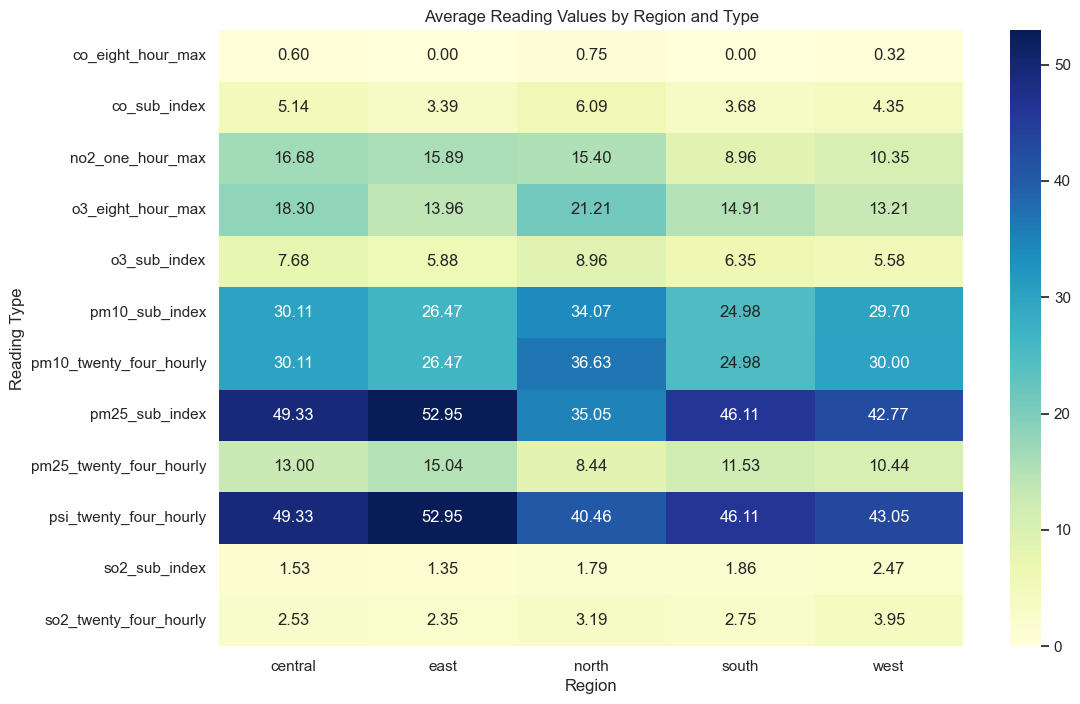

In [160]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

avg_readings = Feb_avg_psi_sg.groupby(['reading_type','region'])['avg_reading_value'].mean().unstack()

plt.figure(figsize=(12, 8))
sns.heatmap(avg_readings, annot=True, cmap="YlGnBu", fmt='.2f')
plt.title('Average Reading Values by Region and Type')
plt.ylabel('Reading Type')
plt.xlabel('Region')
plt.show()

### 3.4 Average PSI Reading Values by Category

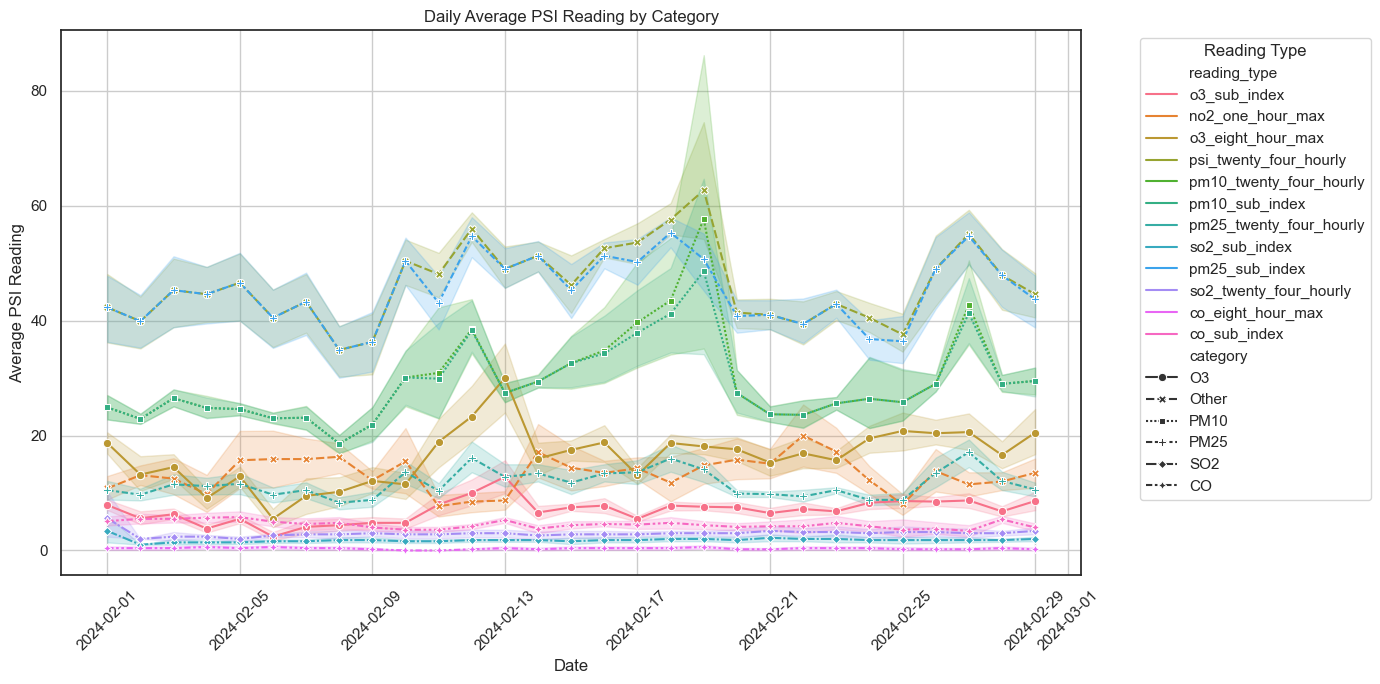

In [161]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


def categorize_reading_type(reading_type):
    if reading_type.startswith('co'):
        return 'CO'
    elif reading_type.startswith('o3'):
        return 'O3'
    elif reading_type.startswith('pm10'):
        return 'PM10'
    elif reading_type.startswith('pm25'):
        return 'PM25'
    elif reading_type.startswith('so2'):
        return 'SO2'
    else:
        return 'Other'


Feb_avg_psi_sg['category'] = Feb_avg_psi_sg['reading_type'].apply(categorize_reading_type)

plt.figure(figsize=(14, 7))
sns.lineplot(data=Feb_avg_psi_sg, 
             x='date', 
             y='avg_reading_value', 
             hue='reading_type',
             style='category', 
             markers=True)

plt.title('Daily Average PSI Reading by Category')
plt.xlabel('Date')
plt.ylabel('Average PSI Reading')
plt.xticks(rotation=45)
plt.legend(title='Reading Type', bbox_to_anchor=(1.05, 1))
plt.grid()
plt.tight_layout()
plt.show()


## 4. Data Modelling and Analysis

In [162]:
Feb_region_traffic_flow_sum = Feb_peakhours_traffic_flow.groupby(['Date', 'region'])['avg_volume'].sum().reset_index()
Feb_region_traffic_flow_sum.columns = ['date', 'region', 'avg_volume']
Feb_region_pollutant_avg = Feb_avg_psi_sg.groupby(['date', 'region', 'reading_type'])['avg_reading_value'].mean().unstack().reset_index()
Feb_merged_data = pd.merge(Feb_region_traffic_flow_sum, Feb_region_pollutant_avg, on=['date', 'region'], how='left')


In [163]:
from sklearn.preprocessing import StandardScaler

# Standardize the numerical columns
standard_scaler = StandardScaler()
Feb_normalized_data = standard_scaler.fit_transform(Feb_merged_data[['avg_volume', 'co_eight_hour_max', 'co_sub_index', 'no2_one_hour_max', 'o3_eight_hour_max', 'o3_sub_index', 'pm10_sub_index', 'pm10_twenty_four_hourly', 'pm25_sub_index', 'pm25_twenty_four_hourly', 'psi_twenty_four_hourly', 'so2_sub_index', 'so2_twenty_four_hourly']])
Feb_normalized_merge_data = Feb_merged_data
Feb_normalized_merge_data[['avg_volume', 'co_eight_hour_max', 'co_sub_index', 'no2_one_hour_max', 'o3_eight_hour_max', 'o3_sub_index', 'pm10_sub_index', 'pm10_twenty_four_hourly', 'pm25_sub_index', 'pm25_twenty_four_hourly', 'psi_twenty_four_hourly', 'so2_sub_index', 'so2_twenty_four_hourly']] = pd.DataFrame(Feb_normalized_data)
print("DataFrame after StandardScaler Scaling (Normalization):")

# Display the first few rows of the standardized DataFrame
Feb_normalized_merge_data

DataFrame after StandardScaler Scaling (Normalization):


,date,region,avg_volume,co_eight_hour_max,co_sub_index,no2_one_hour_max,o3_eight_hour_max,o3_sub_index,pm10_sub_index,pm10_twenty_four_hourly,pm25_sub_index,pm25_twenty_four_hourly,psi_twenty_four_hourly,so2_sub_index,so2_twenty_four_hourly
0,2024-02-01,central,0.053319,1.421560,0.992750,0.515180,0.241654,0.206394,0.195934,0.108442,0.863290,0.670924,0.681997,0.193316,0.025304
1,2024-02-01,east,1.167585,-0.703452,0.324774,-0.553152,-0.210473,-0.328020,-0.444161,-0.385311,0.699589,0.244863,0.530944,8.892543,9.198029
2,2024-02-01,north,0.063999,1.421560,1.660726,-0.224435,1.070554,1.097085,-0.838066,-0.689159,-1.919635,-1.317362,-1.885909,-0.773265,-0.586211
3,2024-02-01,south,0.096246,-0.703452,-0.343201,-0.881870,-0.059764,0.028256,-0.493399,-0.423292,0.044783,-0.181198,-0.073270,0.193316,0.025304
4,2024-02-01,west,1.397425,-0.703452,-0.677189,-0.964049,0.693781,0.740809,-0.444161,-0.385311,-1.210262,-1.033321,-1.231345,-0.773265,-0.586211
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
140,2024-02-29,central,0.141662,1.421560,0.992750,-0.142255,2.200872,2.165913,0.195934,0.108442,0.481320,0.102842,0.329539,0.193316,0.025304
141,2024-02-29,east,1.423617,-0.703452,-0.343201,0.433000,0.090945,0.028256,-0.197971,-0.195406,0.754156,0.386883,0.581295,-0.773265,-0.586211
142,2024-02-29,north,0.083157,-0.703452,-0.343201,1.090435,1.296617,1.275223,0.540600,0.374309,-1.646799,-1.317362,-1.180994,0.193316,0.636819
143,2024-02-29,south,0.023293,-0.703452,-1.011177,-0.388793,-0.135118,-0.149882,-0.591875,-0.499254,-0.064352,-0.181198,-0.173972,0.193316,0.025304


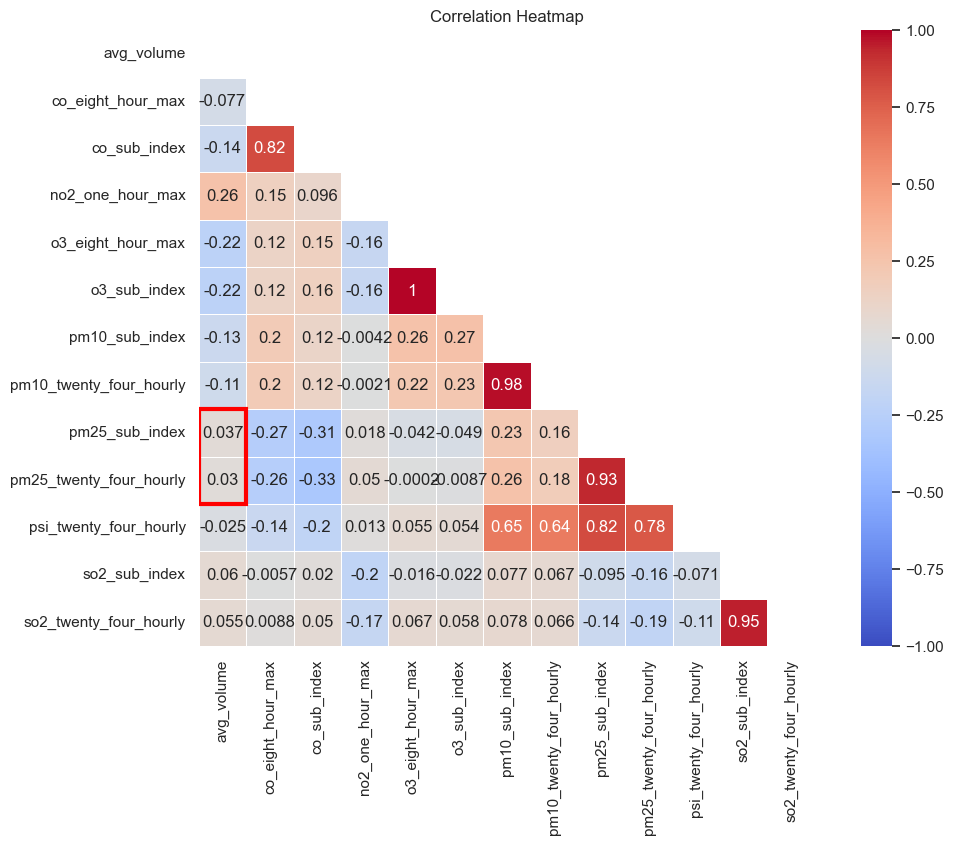

In [164]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Rectangle

correlation_matrix = Feb_normalized_merge_data.drop(columns=['region','date']).corr()
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
sns.set(style="white")
plt.figure(figsize=(12, 8))
heatmap = sns.heatmap(correlation_matrix, mask=mask, annot=True, cmap='coolwarm', vmin=-1, vmax=1, square=True, linewidths=.5)
plt.title('Correlation Heatmap')
row = correlation_matrix.columns.get_loc('pm25_sub_index')  
col = correlation_matrix.columns.get_loc('avg_volume') 

# highlight the correlation result
heatmap.add_patch(plt.Rectangle((col, row), 1, 2, fill=False, edgecolor='red', lw=3))

plt.show()

In [165]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

X = Feb_merged_data[['pm10_twenty_four_hourly', 'pm10_sub_index', 'co_sub_index', 'o3_eight_hour_max','o3_sub_index', 'no2_one_hour_max', 'co_eight_hour_max', 'co_sub_index' ]]
y = Feb_merged_data['avg_volume']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")

coefficients = pd.DataFrame(model.coef_, X.columns, columns=['Coefficient'])
print(coefficients)

Mean Squared Error: 1.0254919132499263
R-squared: 0.0789986836804738
                          Coefficient
pm10_twenty_four_hourly  3.313271e-01
pm10_sub_index          -4.223948e-01
co_sub_index             4.040988e+13
o3_eight_hour_max       -5.601384e-01
o3_sub_index             3.831686e-01
no2_one_hour_max         1.851610e-01
co_eight_hour_max        4.820052e-02
co_sub_index            -4.040988e+13


## 5. Comparative Analysis - Hong Kong

### 5.1 Data Collection

#### 5.1.1 Hong Kong Traffic Data
<p>The Hong Kong traffic data is sourced from the Hong Kong Government Data Center (Transport Department). The traffic data is collected by Traffic Detectors Installed at Smart Lampposts.Data format is XML, and update frequency is every 30 seconds.</p>
<p>You can access the data using the following link: <a href="https://data.gov.hk/en-data/dataset/hk-td-tis_33-traffic-data-traffic-detectors-installed-at-smart-lampposts/resource/b914e460-1042-4a25-8940-7a4687ef254b">Hong Kong Traffic Data</a>.</p>


In [166]:
import os
import xml.etree.ElementTree as ET
import pandas as pd


def process_hk_traffic_data(folder_name):
    # to get the data from another folder in the directory
    current_directory = os.getcwd()
    folder_path = os.path.join(current_directory, folder_name)

    # check if the folder exists before processing
    if not os.path.exists(folder_path):
        raise FileNotFoundError(f"Error: The folder path '{folder_path}' does not exist. Processing stopped.")
    else:
        print(f"Start processing XML files from folder: {folder_path}")

    hk_traffic_data = []

    # Iterate over all files in the folder
    for file_name in os.listdir(folder_path):
        if file_name.endswith("-rawSpeedVol_SLP-all.xml"):
            file_path = os.path.join(folder_path, file_name)
            try:
                tree = ET.parse(file_path)
                root = tree.getroot()
                
                date = root.find('date').text
                
                for period in root.findall('./periods/period'):
                    period_from = period.find('period_from').text
                    period_to = period.find('period_to').text
                    
                    for detector in period.findall('./detectors/detector'):
                        detector_id = detector.find('detector_id').text
                        direction = detector.find('direction').text
                        
                        for lane in detector.findall('./lanes/lane'):
                            lane_id = lane.find('lane_id').text
                            speed = lane.find('speed').text
                            occupancy = lane.find('occupancy').text
                            volume = lane.find('volume').text
                            std_dev = lane.find('s.d.').text
                            valid = lane.find('valid').text
                            
                            # put data to list
                            hk_traffic_data.append({
                                'date': date,
                                'period_from': period_from,
                                'period_to': period_to,
                                'detector_id': detector_id,
                                'direction': direction,
                                'lane_id': lane_id,
                                'speed': speed,
                                'occupancy': occupancy,
                                'volume': volume,
                                'std_dev': std_dev,
                                'valid': valid
                            })
                            
            except Exception as e:
                print(f"Error processing file {file_name}: {e}")


    hk_traffic_df = pd.DataFrame(hk_traffic_data)
    return hk_traffic_df


In [167]:
# data from 6 - 7
hk_traffic_df = process_hk_traffic_data('traffic_data_hk')
print(hk_traffic_df.head())

Start processing XML files from folder: /Users/lin/Desktop/G12_GuidedProject/traffic_data_hk


         date period_from period_to detector_id direction    lane_id speed  \
0  2024-02-26    07:15:00  07:15:30    AID20051      West  Fast Lane    33   
1  2024-02-26    07:15:00  07:15:30    AID20051      West  Slow Lane    50   
2  2024-02-26    07:15:00  07:15:30    AID20012      West  Fast Lane    27   
3  2024-02-26    07:15:00  07:15:30    AID20012      West  Slow Lane    21   
4  2024-02-26    07:15:00  07:15:30    AID20021      East  Slow Lane    50   

  occupancy volume std_dev valid  
0        10      2     1.4     Y  
1         3      0       0     Y  
2        14      4       5     Y  
3         5      1       0     Y  
4         0      0       0     Y  


In [168]:
#https://portal.csdi.gov.hk/geoportal/?datasetId=td_rcd_1671693670072_72800&lang=en
hk_full_traffic_df = process_hk_traffic_data('full_raw_traffic_data_hk')
csv_file = 'traffic_data_full_hk.csv'
hk_full_traffic_df.to_csv(csv_file, index=False)

Start processing XML files from folder: /Users/lin/Desktop/G12_GuidedProject/full_raw_traffic_data_hk


In [169]:
# only use 1% of the data randomly as full data has more than 80w entries
hk_full_traffic_df = pd.read_csv(csv_file).sample(frac=0.01, random_state=42)
print(hk_full_traffic_df.count)

<bound method DataFrame.count of               date period_from period_to detector_id direction    lane_id  \
395109  2024-02-17    12:37:00  12:37:30    AID20057     North  Slow Lane   
752690  2024-02-27    05:01:30  05:02:00    AID20023      West  Fast Lane   
395938  2024-02-19    19:58:00  19:58:30    AID20032     North  Slow Lane   
257479  2024-02-23    12:07:00  12:07:30    AID20053      East  Fast Lane   
563670  2024-02-19    11:47:00  11:47:30    AID20052      East  Fast Lane   
...            ...         ...       ...         ...       ...        ...   
562615  2024-02-16    08:03:00  08:03:30    AID20059     South  Fast Lane   
500092  2024-02-24    15:53:00  15:53:30    AID20056     South  Slow Lane   
449583  2024-02-19    09:41:00  09:41:30    AID20055     North  Slow Lane   
485145  2024-02-25    18:33:30  18:34:00    AID20052      East  Fast Lane   
94792   2024-02-28    09:26:00  09:26:30    AID20024      West  Fast Lane   

        speed  occupancy  volume  std_dev 

In [170]:
print(hk_traffic_df.describe())

              date period_from period_to detector_id direction    lane_id  \
count        35804       35804     35804       35804     35804      35804   
unique          14         152       152          20         4          3   
top     2024-02-29    07:59:00  07:59:30    AID20060     North  Fast Lane   
freq          3136         416       416        3342     10074      17912   

        speed occupancy volume std_dev  valid  
count   35804     35804  35804   35804  35804  
unique    108        82     16     285      1  
top        50         0      0       0      Y  
freq    17059     14229  17155   24854  35804  


#### 5.1.2 Hong Kong Air Quality Index Data


In [171]:
import pandas as pd

# read the hk air quality data file
file_path = '202402_HK_air_quality.csv'

# Read the CSV file with specified encoding for Chinese characters
hk_air_quality_df = pd.read_csv(file_path, encoding='gbk')

print(hk_air_quality_df.head())

print(hk_air_quality_df.tail())

print(hk_air_quality_df.dtypes)

         日期 时间 中西区 南区 东区  观塘 深水埗  葵涌 荃湾 将军澳 元朗 屯门 东涌 大埔  沙田 北区 塔门 铜锣湾 中环 旺角
0  2024/2/1  1   4  3  4   4   4   3  3   4  3  3  3  3   3  3  3   4  4  4
1  2024/2/1  2   3  3  4   4   3   3  3   4  3  3  3  3   3  3  3   3  4  3
2  2024/2/1  3   3  3  3   3   3   3  3   4  3  3  3  3   3  3  3   3  3  3
3  2024/2/1  4   3  3  3   3   3   3  3   3  2  3  3  3   3  3  3   3  3  3
4  2024/2/1  5   3  3  3  3*   3  3*  3   3  2  3  3  3  3*  3  3   3  3  3
            日期     时间 中西区 南区 东区 观塘 深水埗 葵涌 荃湾 将军澳 元朗 屯门 东涌 大埔 沙田 北区 塔门 铜锣湾 中环  \
720  2024/2/29     21   2  2  2  2   2  2  2   2  2  2  2  2  2  2  2   3  3   
721  2024/2/29     22   2  2  2  2   2  2  2   2  2  2  2  2  2  2  2   3  2   
722  2024/2/29     23   2  2  2  2   2  2  2   2  2  2  2  2  2  2  2   3  2   
723  2024/2/29     24   2  2  2  2   2  2  2   2  2  2  2  2  2  2  2   3  2   
724  2024/2/29  每日最高值   4  4  5  4   5  5  5   4  4  5  4  5  4  4  4   5  5   

    旺角  
720  2  
721  2  
722  2  
723  2  
724  5  
日期     ob

#### 5.1.3 Hong Kong Air Pollutants Data

In [172]:
# read the hk air quality data file
file_path = 'hk_air_pollutant_hourly.csv'

hk_air_pollutants_df = pd.read_csv(file_path)

print(hk_air_pollutants_df.head())

print(hk_air_pollutants_df.dtypes)

       DATE  HOUR       STATION SO2  NOX NO2  CO  O3 FSP
0  1/2/2024     1  CAUSEWAY BAY   3  117  56  50  39  28
1  1/2/2024     2  CAUSEWAY BAY   3   63  41  54  45  17
2  1/2/2024     3  CAUSEWAY BAY   2  105  63  67  30  23
3  1/2/2024     4  CAUSEWAY BAY   3  150  75  82  11  15
4  1/2/2024     5  CAUSEWAY BAY   3  114  59  61  20  18
DATE       object
HOUR        int64
STATION    object
SO2        object
NOX        object
NO2        object
CO         object
O3         object
FSP        object
dtype: object



### 5.2 Data Cleaning


#### 5.2.1 Hong Kong Traffic Data
<p>To better utilize the HK traffic dataframe generated, data cleaning technics are used to convert numeric columns to numeric, and convert date column to datetime format. Additionally, missing values are also checked and dropped if any. </p>

In [173]:

# Data Cleaning
# Convert columns to numeric data types
hk_traffic_df['speed'] = pd.to_numeric(hk_traffic_df['speed'], errors='coerce')
hk_traffic_df['occupancy'] = pd.to_numeric(hk_traffic_df['occupancy'], errors='coerce')
hk_traffic_df['volume'] = pd.to_numeric(hk_traffic_df['volume'], errors='coerce')
hk_traffic_df['std_dev'] = pd.to_numeric(hk_traffic_df['std_dev'], errors='coerce')

# Convert 'date' column to datetime for time series analysis
hk_traffic_df['date'] = pd.to_datetime(hk_traffic_df['date'])

# Convert 'period_from' to datetime format for easier handling
hk_traffic_df['period_from'] = pd.to_datetime(hk_traffic_df['period_from'], format='%H:%M:%S')
hk_traffic_df['time'] = hk_traffic_df['period_from'].dt.hour.astype(int)
hk_traffic_df = hk_traffic_df.drop(columns=['period_from', 'period_to'])

# Check for missing values
missing_values = hk_traffic_df.isnull().sum()
print("Missing values in each column:")
print(missing_values)

# Drop rows with missing values
hk_traffic_df.dropna(inplace=True)

# Drop rows with invalid indicator
hk_traffic_df = hk_traffic_df[hk_traffic_df['valid'] == 'Y']

Missing values in each column:
date           0
detector_id    0
direction      0
lane_id        0
speed          0
occupancy      0
volume         0
std_dev        0
valid          0
time           0
dtype: int64


In [174]:
# Data Cleaning for hk_full_traffic_df
# Convert columns to numeric data types
hk_full_traffic_df['speed'] = pd.to_numeric(hk_full_traffic_df['speed'], errors='coerce')
hk_full_traffic_df['occupancy'] = pd.to_numeric(hk_full_traffic_df['occupancy'], errors='coerce')
hk_full_traffic_df['volume'] = pd.to_numeric(hk_full_traffic_df['volume'], errors='coerce')
hk_full_traffic_df['std_dev'] = pd.to_numeric(hk_full_traffic_df['std_dev'], errors='coerce')

# Convert 'date' column to datetime for time series analysis
hk_full_traffic_df['date'] = pd.to_datetime(hk_full_traffic_df['date'])

# Convert 'period_from' to datetime format for easier handling
hk_full_traffic_df['period_from'] = pd.to_datetime(hk_full_traffic_df['period_from'], format='%H:%M:%S')
hk_full_traffic_df['time'] = hk_full_traffic_df['period_from'].dt.hour.astype(int)
hk_full_traffic_df = hk_full_traffic_df.drop(columns=['period_from', 'period_to'])

# Check for missing values
missing_values_full = hk_full_traffic_df.isnull().sum()
print("Missing values in each column of hk_full_traffic_df:")
print(missing_values_full)

# Drop rows with missing values
hk_full_traffic_df.dropna(inplace=True)

# Drop rows with invalid indicator
hk_full_traffic_df = hk_full_traffic_df[hk_full_traffic_df['valid'] == 'Y']


Missing values in each column of hk_full_traffic_df:
date           0
detector_id    0
direction      0
lane_id        0
speed          0
occupancy      0
volume         0
std_dev        0
valid          0
time           0
dtype: int64


#### 5.2.2 Hong Kong Air Quality Data

In [175]:
# remove all *
hk_air_quality_df.replace(to_replace=r'\*', value='', regex=True, inplace=True)

# update date column to datetime format
hk_air_quality_df['日期'] = pd.to_datetime(hk_air_quality_df['日期'])

hk_air_quality_df.iloc[:, 2:] = hk_air_quality_df.iloc[:, 2:].apply(pd.to_numeric, errors='coerce')

# for na values, fill in mean value
hk_air_quality_df.fillna(hk_air_quality_df.iloc[:, 2:].mean(), inplace=True)


print(hk_air_quality_df.head(10))

          日期  时间  中西区  南区  东区  观塘  深水埗  葵涌  荃湾  将军澳  元朗  屯门  东涌  大埔  沙田  北区  \
0 2024-02-01   1    4   3   4   4    4   3   3    4   3   3   3   3   3   3   
1 2024-02-01   2    3   3   4   4    3   3   3    4   3   3   3   3   3   3   
2 2024-02-01   3    3   3   3   3    3   3   3    4   3   3   3   3   3   3   
3 2024-02-01   4    3   3   3   3    3   3   3    3   2   3   3   3   3   3   
4 2024-02-01   5    3   3   3   3    3   3   3    3   2   3   3   3   3   3   
5 2024-02-01   6    3   3   3   3    3   3   3    3   2   3   3   3   3   3   
6 2024-02-01   7    3   3   3   3    3   3   3    3   2   2   2   3   3   3   
7 2024-02-01   8    3   3   3   3    3   3   3    3   2   2   2   2   3   2   
8 2024-02-01   9    3   3   3   3    3   3   3    3   2   3   3   3   3   2   
9 2024-02-01  10    3   3   3   3    3   3   3    3   2   3   3   3   3   3   

    塔门  铜锣湾  中环  旺角  
0  3.0    4   4   4  
1  3.0    3   4   3  
2  3.0    3   3   3  
3  3.0    3   3   3  
4  3.0    3   3   3 

/var/folders/fg/pr9xmsbj4kb4pxfl91jb5d3h0000gn/T/ipykernel_28409/3015238907.py:10: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  hk_air_quality_df.fillna(hk_air_quality_df.iloc[:, 2:].mean(), inplace=True)


In [176]:

filtered_hk_air_quality_df = hk_air_quality_df[hk_air_quality_df['时间'] != '每日最高值']
filtered_hk_air_quality_df['时间'] = filtered_hk_air_quality_df['时间'].astype('int')
# filtered_hk_air_quality_df = [(hk_air_quality_df['时间'] == '7') | (hk_air_quality_df['时间'] == '8')]
print("\nFiltered HK air quality data for hours 7 and 8 for comparision with SG data:")
print(filtered_hk_air_quality_df.head())


Filtered HK air quality data for hours 7 and 8 for comparision with SG data:
          日期  时间  中西区  南区  东区  观塘  深水埗  葵涌  荃湾  将军澳  元朗  屯门  东涌  大埔  沙田  北区  \
0 2024-02-01   1    4   3   4   4    4   3   3    4   3   3   3   3   3   3   
1 2024-02-01   2    3   3   4   4    3   3   3    4   3   3   3   3   3   3   
2 2024-02-01   3    3   3   3   3    3   3   3    4   3   3   3   3   3   3   
3 2024-02-01   4    3   3   3   3    3   3   3    3   2   3   3   3   3   3   
4 2024-02-01   5    3   3   3   3    3   3   3    3   2   3   3   3   3   3   

    塔门  铜锣湾  中环  旺角  
0  3.0    4   4   4  
1  3.0    3   4   3  
2  3.0    3   3   3  
3  3.0    3   3   3  
4  3.0    3   3   3  


/var/folders/fg/pr9xmsbj4kb4pxfl91jb5d3h0000gn/T/ipykernel_28409/1286717920.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_hk_air_quality_df['时间'] = filtered_hk_air_quality_df['时间'].astype('int')


In [177]:
# Insert new library to do naming translation from Chinese to English
from googletrans import Translator
translator = Translator()

def translate_column_names(df):
    translated_columns = {}
    for col in df.columns:
        # Translate Chinese column name to English
        translated_col = translator.translate(col, dest='en').text
        # use _ to replace the space
        translated_col = translated_col.replace(' ', '_')
        translated_columns[col] = translated_col
    
    # Rename the columns to English
    df.rename(columns=translated_columns, inplace=True)

translate_column_names(filtered_hk_air_quality_df)

filtered_hk_air_quality_df.head()


/var/folders/fg/pr9xmsbj4kb4pxfl91jb5d3h0000gn/T/ipykernel_28409/3925052410.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.rename(columns=translated_columns, inplace=True)


,date,time,Central_and_Western_District,Southern_district,Eastern_district,Guantang,Sham_Shui_Kan,Kwai,Tsuen_Wan,Tseungo,Yuanlang,Tuomao,Tung_Chung,Tai_Po,Sand_field,Northern_district,Tower_door,Causeway_Bay,Central,Mong_Kok
0,2024-02-01,1,4,3,4,4,4,3,3,4,3,3,3,3,3,3,3.0,4,4,4
1,2024-02-01,2,3,3,4,4,3,3,3,4,3,3,3,3,3,3,3.0,3,4,3
2,2024-02-01,3,3,3,3,3,3,3,3,4,3,3,3,3,3,3,3.0,3,3,3
3,2024-02-01,4,3,3,3,3,3,3,3,3,2,3,3,3,3,3,3.0,3,3,3
4,2024-02-01,5,3,3,3,3,3,3,3,3,2,3,3,3,3,3,3.0,3,3,3


In [178]:


def overall_average_air_quality(dataframe):
    # only have columns after first two to do average
    cols_to_convert = dataframe.columns[2:] 
    dataframe[cols_to_convert] = dataframe[cols_to_convert].apply(pd.to_numeric, errors='coerce')
    dataframe['air_average'] = dataframe[cols_to_convert].mean(axis=1)
    # group the average by date
    overall_avg_df = dataframe.groupby(['date', 'time'])['air_average'].mean().reset_index()
    return overall_avg_df


hk_average_air_quality_df = overall_average_air_quality(filtered_hk_air_quality_df)

hk_average_air_quality_df.head()

/var/folders/fg/pr9xmsbj4kb4pxfl91jb5d3h0000gn/T/ipykernel_28409/2109279196.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe[cols_to_convert] = dataframe[cols_to_convert].apply(pd.to_numeric, errors='coerce')
/var/folders/fg/pr9xmsbj4kb4pxfl91jb5d3h0000gn/T/ipykernel_28409/2109279196.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['air_average'] = dataframe[cols_to_convert].mean(axis=1)


,date,time,air_average
0,2024-02-01,1,3.444444
1,2024-02-01,2,3.222222
2,2024-02-01,3,3.055556
3,2024-02-01,4,2.944444
4,2024-02-01,5,2.944444


In [179]:
hk_average_air_quality_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 696 entries, 0 to 695
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   date         696 non-null    datetime64[ns]
 1   time         696 non-null    int64         
 2   air_average  696 non-null    float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 16.4 KB


In [180]:
hk_traffic_df.head()
print(hk_traffic_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35804 entries, 0 to 35803
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   date         35804 non-null  datetime64[ns]
 1   detector_id  35804 non-null  object        
 2   direction    35804 non-null  object        
 3   lane_id      35804 non-null  object        
 4   speed        35804 non-null  int64         
 5   occupancy    35804 non-null  int64         
 6   volume       35804 non-null  int64         
 7   std_dev      35804 non-null  float64       
 8   valid        35804 non-null  object        
 9   time         35804 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(4), object(4)
memory usage: 2.7+ MB
None


#### 5.2.3 Hong Kong Air Pollutants Data

In [181]:
# Data Cleaning for hk_air_pollutants_df
# Convert column names to lowercase
hk_air_pollutants_df.columns = [x.lower() for x in hk_air_pollutants_df.columns]
hk_air_pollutants_df['station'] = [x.lower() for x in hk_air_pollutants_df['station']]
hk_air_pollutants_df.head()

,date,hour,station,so2,nox,no2,co,o3,fsp
0,1/2/2024,1,causeway bay,3,117,56,50,39,28
1,1/2/2024,2,causeway bay,3,63,41,54,45,17
2,1/2/2024,3,causeway bay,2,105,63,67,30,23
3,1/2/2024,4,causeway bay,3,150,75,82,11,15
4,1/2/2024,5,causeway bay,3,114,59,61,20,18


In [182]:
# Check for missing values
hk_air_pollutants_df.replace('N.A.', np.nan, inplace=True)
print(hk_air_pollutants_df.isnull().sum())

# Convert pollutant index columns to numeric data types
hk_air_pollutants_df['so2'] = pd.to_numeric(hk_air_pollutants_df['so2'])
hk_air_pollutants_df['nox'] = pd.to_numeric(hk_air_pollutants_df['nox'])
hk_air_pollutants_df['no2'] = pd.to_numeric(hk_air_pollutants_df['no2'])
hk_air_pollutants_df['co'] = pd.to_numeric(hk_air_pollutants_df['co'])
hk_air_pollutants_df['o3'] = pd.to_numeric(hk_air_pollutants_df['o3'])
hk_air_pollutants_df['fsp'] = pd.to_numeric(hk_air_pollutants_df['fsp'])

# Convert 'date' column to datetime
hk_air_pollutants_df['date'] = pd.to_datetime(hk_air_pollutants_df['date'],format='%d/%m/%Y')


hk_air_pollutants_df['station'] = hk_air_pollutants_df['station'].astype('str')
hk_air_pollutants_df['station'] = hk_air_pollutants_df['station'].str.replace('/',  ' & ')


date          0
hour          0
station       0
so2         338
nox        1079
no2         388
co         5091
o3          301
fsp         301
dtype: int64


In [183]:
hk_air_pollutants_columns = hk_air_pollutants_df.iloc[:,3:].columns
print(hk_air_pollutants_columns)

Index(['so2', 'nox', 'no2', 'co', 'o3', 'fsp'], dtype='object')


In [184]:
# for missing values, fillna with mean value of that station
for col in hk_air_pollutants_columns:
    hk_air_pollutants_df[col] = hk_air_pollutants_df.groupby('station')[col].transform(lambda x: x.fillna(x.mean()))
    #station_mean = hk_air_pollutants_df.groupby('station')[col].mean()
    #hk_air_pollutants_df[col].fillna(station_mean, inplace=True)
print(hk_air_pollutants_df.isnull().sum()) 

date          0
hour          0
station       0
so2           0
nox         696
no2           0
co         4872
o3            0
fsp           0
dtype: int64


In [185]:
# some null values are due to missing pollutant data for the whole station; for such cases, use the mean of all area to fill na
hk_nox_mean = hk_air_pollutants_df['nox'].mean()
print(hk_nox_mean)
hk_air_pollutants_df['nox'].fillna(hk_nox_mean,inplace=True)

hk_co_mean = hk_air_pollutants_df['co'].mean()
print(hk_co_mean)
hk_air_pollutants_df['co'].fillna(hk_co_mean,inplace=True)

print(hk_air_pollutants_df.isnull().sum())

63.98421705445338
59.06501039965298
date       0
hour       0
station    0
so2        0
nox        0
no2        0
co         0
o3         0
fsp        0
dtype: int64


/var/folders/fg/pr9xmsbj4kb4pxfl91jb5d3h0000gn/T/ipykernel_28409/3512532905.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  hk_air_pollutants_df['nox'].fillna(hk_nox_mean,inplace=True)
/var/folders/fg/pr9xmsbj4kb4pxfl91jb5d3h0000gn/T/ipykernel_28409/3512532905.py:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting

In [186]:
hk_air_pollutants_daily_average_df = hk_air_pollutants_df.groupby('date')[hk_air_pollutants_columns].mean().reset_index()
hk_air_pollutants_daily_average_df = hk_air_pollutants_daily_average_df[15:]

hk_full_traffic_daily_average_df = hk_full_traffic_df.groupby('date')[['speed','occupancy','volume']].mean().reset_index()

# merge daily average with the traffic data
merged_pollutant_traffic_daily_average_df = pd.merge(hk_air_pollutants_daily_average_df, hk_full_traffic_daily_average_df, on='date')
merged_pollutant_traffic_daily_average_df.head()

,date,so2,nox,no2,co,o3,fsp,speed,occupancy,volume
0,2024-02-16,2.985930,69.430678,40.018588,61.942251,50.033687,18.945219,42.552960,6.551402,1.464174
1,2024-02-17,2.164621,41.479834,28.930632,54.056273,70.411975,13.166873,42.509687,6.570790,1.614009
2,2024-02-18,2.688407,45.898770,31.109148,54.243283,58.632141,14.972389,44.553064,5.206278,1.281016
3,2024-02-19,3.502490,70.193065,38.216070,51.633528,26.268014,12.507591,42.058085,6.708006,1.540031
4,2024-02-20,3.261248,58.649766,33.444147,48.949256,34.696661,10.856939,41.220907,7.928994,1.731755


In [187]:
merged_pollutant_traffic_daily_average_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 10 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   date       14 non-null     datetime64[ns]
 1   so2        14 non-null     float64       
 2   nox        14 non-null     float64       
 3   no2        14 non-null     float64       
 4   co         14 non-null     float64       
 5   o3         14 non-null     float64       
 6   fsp        14 non-null     float64       
 7   speed      14 non-null     float64       
 8   occupancy  14 non-null     float64       
 9   volume     14 non-null     float64       
dtypes: datetime64[ns](1), float64(9)
memory usage: 1.2 KB


In [188]:
print("DataFrame before Min-Max Scaling (Normalisation):")
print(merged_pollutant_traffic_daily_average_df.to_string(index=False))

normalised_data = min_max_scaler.fit_transform(merged_pollutant_traffic_daily_average_df.iloc[:,1:])
merged_pollutant_traffic_daily_average_df.iloc[:,1:] = normalised_data

print("DataFrame after Min-Max Scaling (Normalisation):")
print(merged_pollutant_traffic_daily_average_df.to_string(index=False))

DataFrame before Min-Max Scaling (Normalisation):
      date      so2       nox       no2        co        o3       fsp     speed  occupancy   volume
2024-02-16 2.985930 69.430678 40.018588 61.942251 50.033687 18.945219 42.552960   6.551402 1.464174
2024-02-17 2.164621 41.479834 28.930632 54.056273 70.411975 13.166873 42.509687   6.570790 1.614009
2024-02-18 2.688407 45.898770 31.109148 54.243283 58.632141 14.972389 44.553064   5.206278 1.281016
2024-02-19 3.502490 70.193065 38.216070 51.633528 26.268014 12.507591 42.058085   6.708006 1.540031
2024-02-20 3.261248 58.649766 33.444147 48.949256 34.696661 10.856939 41.220907   7.928994 1.731755
2024-02-21 3.524209 62.182298 35.514790 47.727302 39.700323 11.637673 41.017391   8.319565 1.945652
2024-02-22 3.305048 63.905316 34.628836 47.430957 30.224548 14.410144 40.043977   8.650096 1.973231
2024-02-23 2.782349 57.934935 32.374810 58.256113 26.621571 16.681600 40.409171   8.844797 1.844797
2024-02-24 3.125591 70.198601 37.763499 61.132127 

In [189]:
merge_hk_traffic_air_df = pd.merge(hk_average_air_quality_df, hk_full_traffic_df, on=['date', 'time'] )
merge_hk_traffic_air_df = merge_hk_traffic_air_df.rename(columns={'time': 'hour'})
full_hk_traffic_air_df = pd.merge(merge_hk_traffic_air_df, hk_air_pollutants_df, on=['date', 'hour'])

In [190]:
full_hk_traffic_air_df.head()

,date,hour,air_average,detector_id,direction,lane_id,speed,occupancy,volume,std_dev,valid,station,so2,nox,no2,co,o3,fsp
0,2024-02-15,23,3.166667,AID20057,North,Fast Lane,50,0,0,0.0,Y,causeway bay,8.0,432.000000,97.0,105.00000,7.0,26.0
1,2024-02-15,23,3.166667,AID20057,North,Fast Lane,50,0,0,0.0,Y,central,6.0,285.000000,102.0,122.00000,4.0,23.0
2,2024-02-15,23,3.166667,AID20057,North,Fast Lane,50,0,0,0.0,Y,central & western,2.0,38.000000,35.0,59.06501,67.0,13.0
3,2024-02-15,23,3.166667,AID20057,North,Fast Lane,50,0,0,0.0,Y,eastern,2.0,63.984217,62.0,59.06501,43.0,15.0
4,2024-02-15,23,3.166667,AID20057,North,Fast Lane,50,0,0,0.0,Y,kwai chung,6.0,200.000000,96.0,59.06501,2.0,18.0


### 5.3 Exploratory Data Analysis (EDA) Snapshot of Hong Kong

#### 5.3.1 Correlation of Air Quality Index and Region 

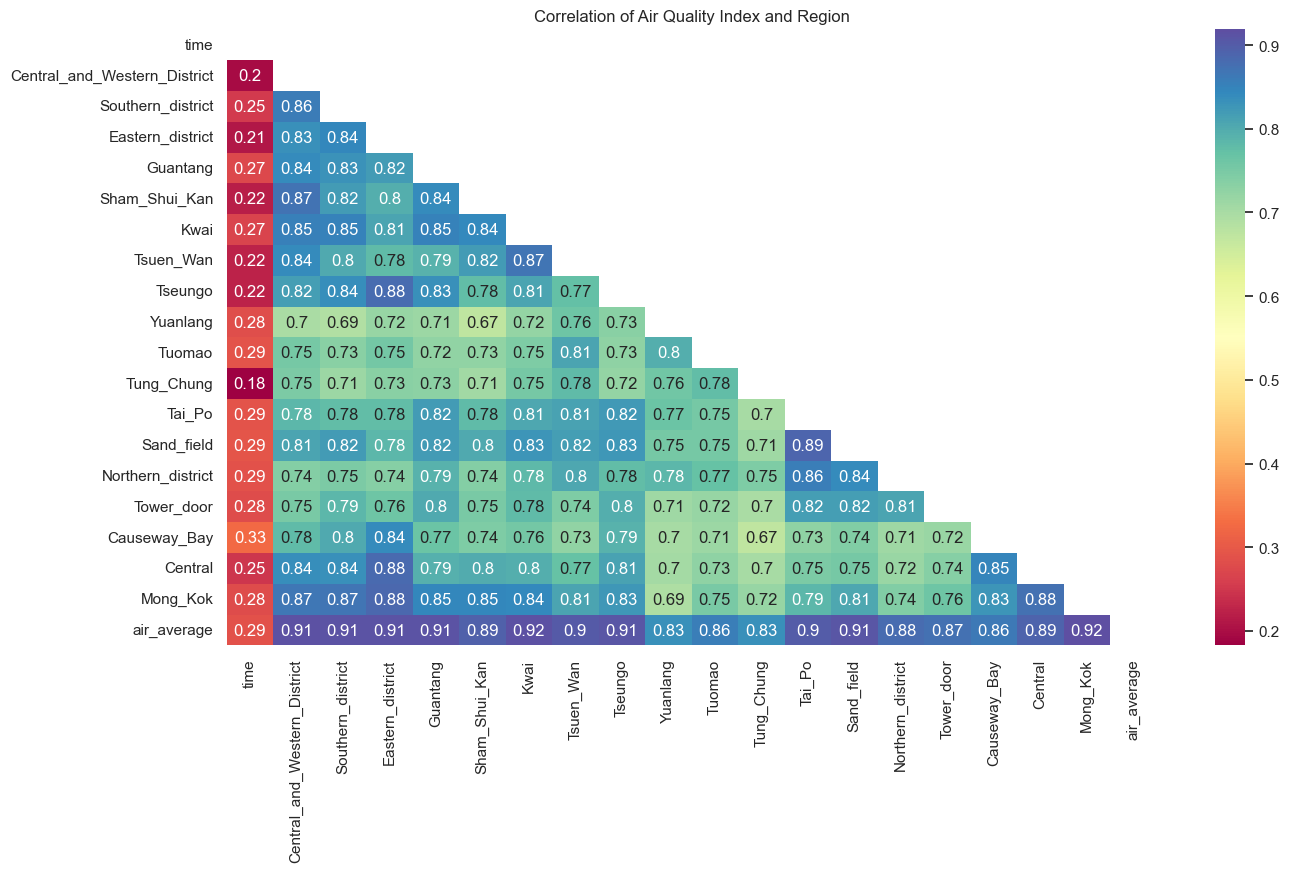

In [191]:
corr_matrix = filtered_hk_air_quality_df.drop(columns=['date']).corr()

plt.figure(figsize=(15, 8))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(corr_matrix, annot=True,mask=mask, cmap='Spectral')
plt.title('Correlation of Air Quality Index and Region')
plt.show()

#### 5.3.2 Daily Traffic Volume Trend & Air Pollution Trend Over Time

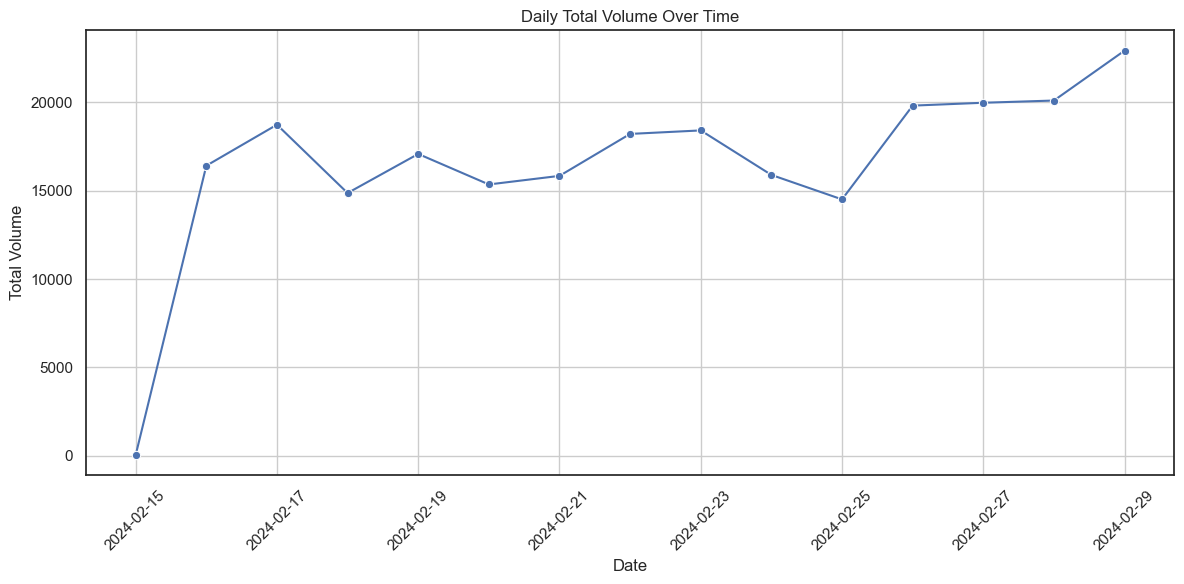

In [192]:
# Grouping by date to analyze total volume per day
daily_volume = full_hk_traffic_air_df.groupby('date')['volume'].sum().reset_index()

plt.figure(figsize=(12, 6))
sns.lineplot(data=daily_volume, x='date', y='volume', marker='o')
plt.title('Daily Total Volume Over Time')
plt.xlabel('Date')
plt.ylabel('Total Volume')
plt.xticks(rotation=45)
plt.grid()
plt.tight_layout()
plt.show()

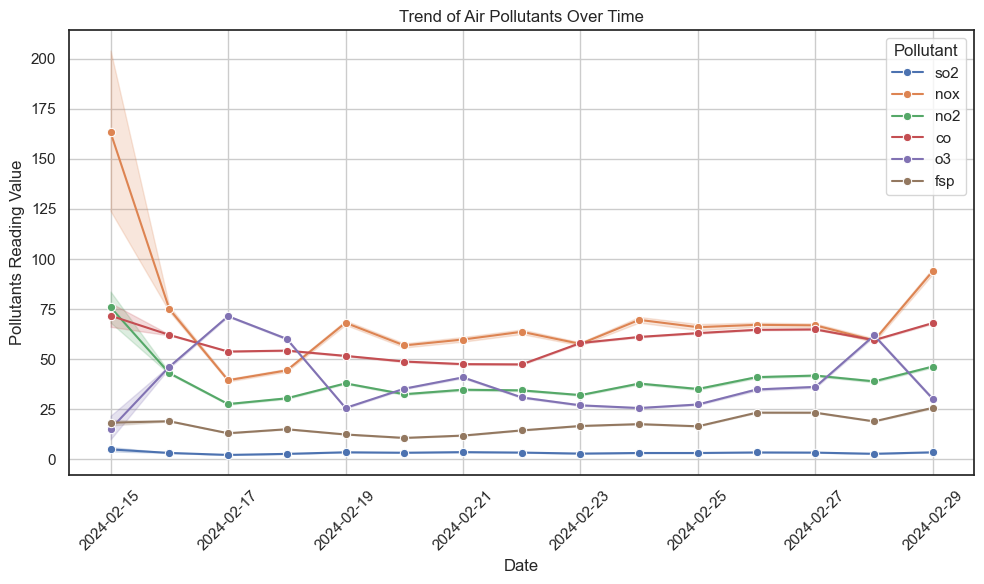

In [193]:
melted_df = full_hk_traffic_air_df.melt(id_vars=['date', 'hour'], value_vars=['so2', 'nox', 'no2', 'co', 'o3', 'fsp'],
                    var_name='Pollutant', value_name='summary')

# Plotting
plt.figure(figsize=(10, 6))
sns.lineplot(data=melted_df, x='date', y='summary', hue='Pollutant', marker='o')
plt.title('Trend of Air Pollutants Over Time')
plt.xlabel('Date')
plt.ylabel('Pollutants Reading Value')
plt.xticks(rotation=45)
plt.grid()
plt.tight_layout()
plt.show()

#### 5.3.3 Correlations between Hong Kong Air Pollutants and Traffic Flow 

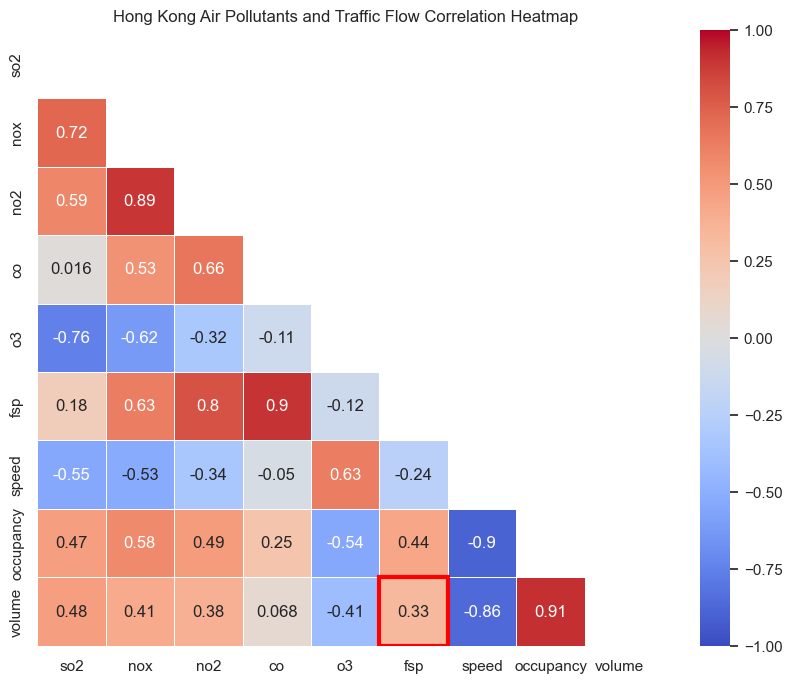

In [194]:
pollutants_traffic_correlation_matrix = merged_pollutant_traffic_daily_average_df.iloc[:,1:].corr()
mask = np.triu(np.ones_like(pollutants_traffic_correlation_matrix, dtype=bool))
plt.figure(figsize=(12, 8))
heatmap = sns.heatmap(pollutants_traffic_correlation_matrix, mask=mask, annot=True, cmap='coolwarm', vmin=-1, vmax=1, square=True, linewidths=.5)

plt.title('Hong Kong Air Pollutants and Traffic Flow Correlation Heatmap')

row = pollutants_traffic_correlation_matrix.columns.get_loc('volume')  
col = pollutants_traffic_correlation_matrix.columns.get_loc('fsp') 

# highlight the correlation result
heatmap.add_patch(plt.Rectangle((col, row), 1, 1, fill=False, edgecolor='red', lw=3))
plt.show()

### 5.4 Data Modelling and Analysis

In [195]:
merge_hk_traffic_air_df = pd.merge(hk_average_air_quality_df, hk_full_traffic_df, on=['date', 'time'] )
merge_hk_traffic_air_df = merge_hk_traffic_air_df.rename(columns={'time': 'hour'})
full_hk_traffic_air_df = pd.merge(merge_hk_traffic_air_df, hk_air_pollutants_df, on=['date', 'hour'])

In [196]:
full_hk_traffic_air_df.head()

,date,hour,air_average,detector_id,direction,lane_id,speed,occupancy,volume,std_dev,valid,station,so2,nox,no2,co,o3,fsp
0,2024-02-15,23,3.166667,AID20057,North,Fast Lane,50,0,0,0.0,Y,causeway bay,8.0,432.000000,97.0,105.00000,7.0,26.0
1,2024-02-15,23,3.166667,AID20057,North,Fast Lane,50,0,0,0.0,Y,central,6.0,285.000000,102.0,122.00000,4.0,23.0
2,2024-02-15,23,3.166667,AID20057,North,Fast Lane,50,0,0,0.0,Y,central & western,2.0,38.000000,35.0,59.06501,67.0,13.0
3,2024-02-15,23,3.166667,AID20057,North,Fast Lane,50,0,0,0.0,Y,eastern,2.0,63.984217,62.0,59.06501,43.0,15.0
4,2024-02-15,23,3.166667,AID20057,North,Fast Lane,50,0,0,0.0,Y,kwai chung,6.0,200.000000,96.0,59.06501,2.0,18.0


In [197]:
data_encoded = pd.get_dummies(merge_hk_traffic_air_df, columns=['direction'], dtype=int)
# Display the first few rows of the encoded DataFrame
data_encoded.head()

,date,hour,air_average,detector_id,lane_id,speed,occupancy,volume,std_dev,valid,direction_East,direction_North,direction_South,direction_West
0,2024-02-15,23,3.166667,AID20057,Fast Lane,50,0,0,0.0,Y,0,1,0,0
1,2024-02-15,23,3.166667,AID20011,Fast Lane,27,10,2,4.2,Y,1,0,0,0
2,2024-02-16,1,3.222222,AID20030,Fast Lane,42,2,1,0.0,Y,0,1,0,0
3,2024-02-16,1,3.222222,AID20058,Slow Lane,49,4,3,2.5,Y,0,0,1,0
4,2024-02-16,1,3.222222,AID20023,Slow Lane,50,2,0,0.0,Y,0,0,0,1


In [198]:
from sklearn.preprocessing import StandardScaler

# Identify the numerical columns to standardize
numerical_cols = ['speed', 'occupancy', 'volume']

# Standardize the numerical columns
scaler = StandardScaler()
data_encoded[numerical_cols] = scaler.fit_transform(data_encoded[numerical_cols])

# Display the first few rows of the standardized DataFrame
data_encoded.head()


,date,hour,air_average,detector_id,lane_id,speed,occupancy,volume,std_dev,valid,direction_East,direction_North,direction_South,direction_West
0,2024-02-15,23,3.166667,AID20057,Fast Lane,0.605877,-0.608935,-0.713904,0.0,Y,0,1,0,0
1,2024-02-15,23,3.166667,AID20011,Fast Lane,-1.047524,0.156832,0.098628,4.2,Y,1,0,0,0
2,2024-02-16,1,3.222222,AID20030,Fast Lane,0.030781,-0.455781,-0.307638,0.0,Y,0,1,0,0
3,2024-02-16,1,3.222222,AID20058,Slow Lane,0.533990,-0.302628,0.504895,2.5,Y,0,0,1,0
4,2024-02-16,1,3.222222,AID20023,Slow Lane,0.605877,-0.455781,-0.713904,0.0,Y,0,0,0,1


In [199]:
# Select relevant features
features = data_encoded[['speed', 'occupancy', 'volume', 'air_average']]

print(features)

         speed  occupancy    volume  air_average
0     0.605877  -0.608935 -0.713904     3.166667
1    -1.047524   0.156832  0.098628     3.166667
2     0.030781  -0.455781 -0.307638     3.222222
3     0.533990  -0.302628  0.504895     3.222222
4     0.605877  -0.455781 -0.713904     3.222222
...        ...        ...       ...          ...
7842 -1.335072   0.003679  0.504895     2.055556
7843 -0.544315  -0.379204  0.098628     2.055556
7844  0.605877  -0.608935 -0.713904     2.055556
7845 -0.472428   0.846023  2.129959     2.055556
7846  0.605877  -0.455781 -0.713904     2.055556

[7847 rows x 4 columns]


#### 5.4.1 Hierarchy Clustring
<p>Hierarchy clustering is used to cluster data points based on air quality and traffic data, which could assist to identify hidden patterns or some hidden groupings between air quality and traffic data. </p>

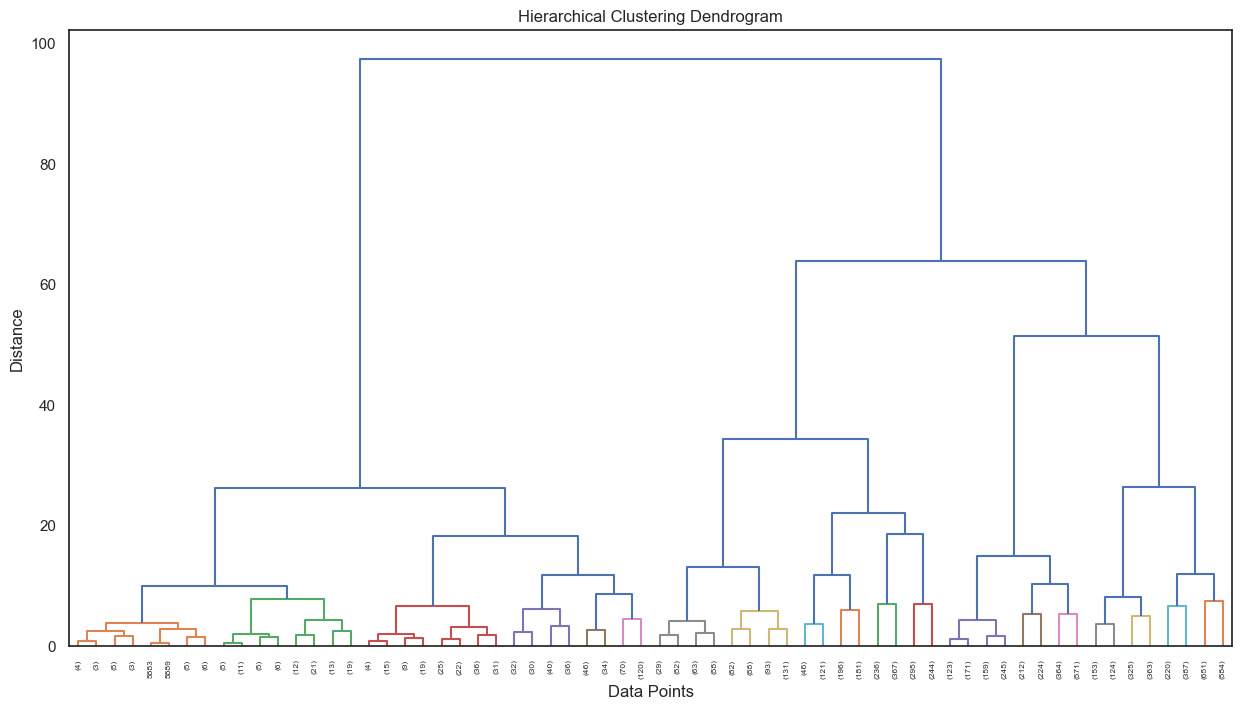

In [200]:
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster

# Select relevant data columns for clustering
features = data_encoded[['volume', 'air_average']]

# Create a new linkage matrix with a different variable name
linkage_matrix = linkage(features, method='ward')

# Plot dendrogram to visualize the hierarchical structure
plt.figure(figsize=(15, 8))

# p limits the depth and truncate model limits the displayed cluster number
dendrogram(linkage_matrix, truncate_mode='level', color_threshold=7.8, p=5)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Data Points')
plt.ylabel('Distance')
plt.show()




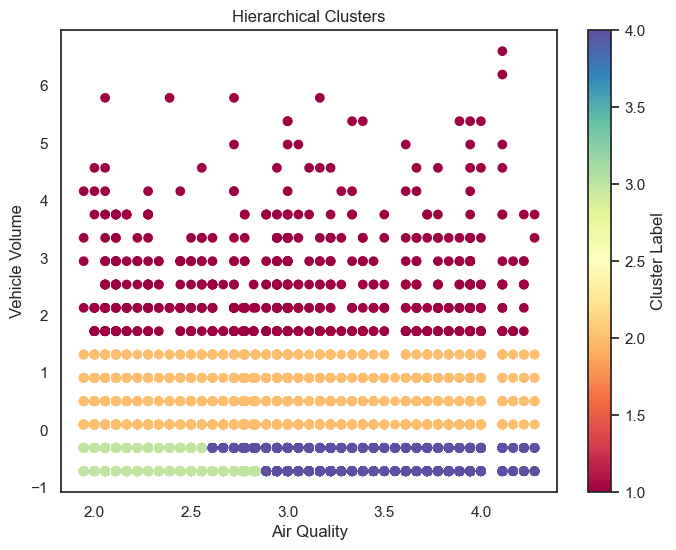

In [201]:
# Choose the number of clusters for subclustering (in above case, 4)
num_clusters = 4

# Assign labels to the cluster based on the number of clusters chosen
cluster_labels = fcluster(linkage_matrix, t=num_clusters, criterion='maxclust')

# Assign the cluster labels to the DataFrame
data_encoded['Hierarchical_Labels'] = cluster_labels

# Scatter plot for the clusters (visualizing 'volume' and 'occupancy')
plt.figure(figsize=(8, 6))
plt.scatter(data_encoded['air_average'], 
            data_encoded['volume'], 
            c=data_encoded['Hierarchical_Labels'], cmap='Spectral')
plt.title('Hierarchical Clusters')
plt.xlabel('Air Quality')
plt.ylabel('Vehicle Volume')
plt.colorbar(label='Cluster Label')
plt.show()

#### 5.4.2 Correlation Between Air Quality and Traffic in Hong Kong

<p>This section provides a visual overview of the correlations among all those numeric fields. It enables uses to easily see the correlations between key traffic factors (such as vehicle volume and occupancy) and air quality measurements (like fsp, the representation of PM2.5) </p>

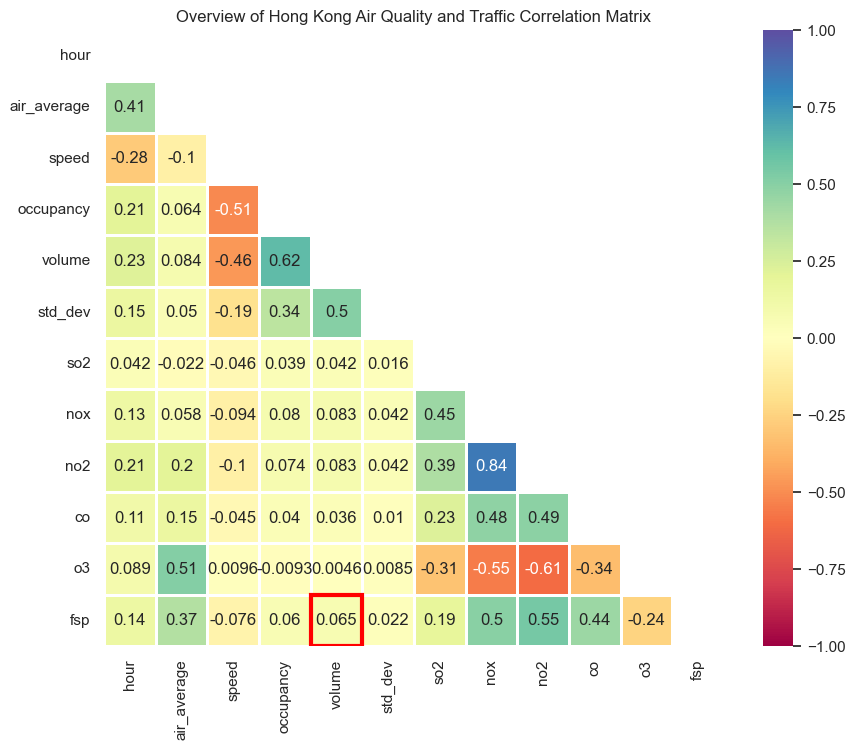

In [202]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

numerical_columns = full_hk_traffic_air_df.select_dtypes(include=['float64', 'int64']).columns

# Calculate correlation matrix
correlation_matrix = full_hk_traffic_air_df[numerical_columns].corr()

# Create a mask to hide the upper triangle
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

# Visualize the correlation matrix with a heatmap
plt.figure(figsize=(10, 8))
ax = sns.heatmap(correlation_matrix, annot=True, cmap='Spectral', linewidths=0.9, vmin=-1, vmax=1, mask=mask)
plt.title("Overview of Hong Kong Air Quality and Traffic Correlation Matrix")

row = correlation_matrix.columns.get_loc('fsp')  
col = correlation_matrix.columns.get_loc('volume') 

# highlight the correlation result
ax.add_patch(plt.Rectangle((col, row), 1, 1, fill=False, edgecolor='red', lw=3))

plt.show()


<p>Below section is trying to identify the relationship of hour and each traffic factor (like vehicle volume) and air quality measurement. From the picture below, it is indicated that the air measurements all tend to increase during the period from noon to late afternoon.(from the change of the color of correlation)</p>

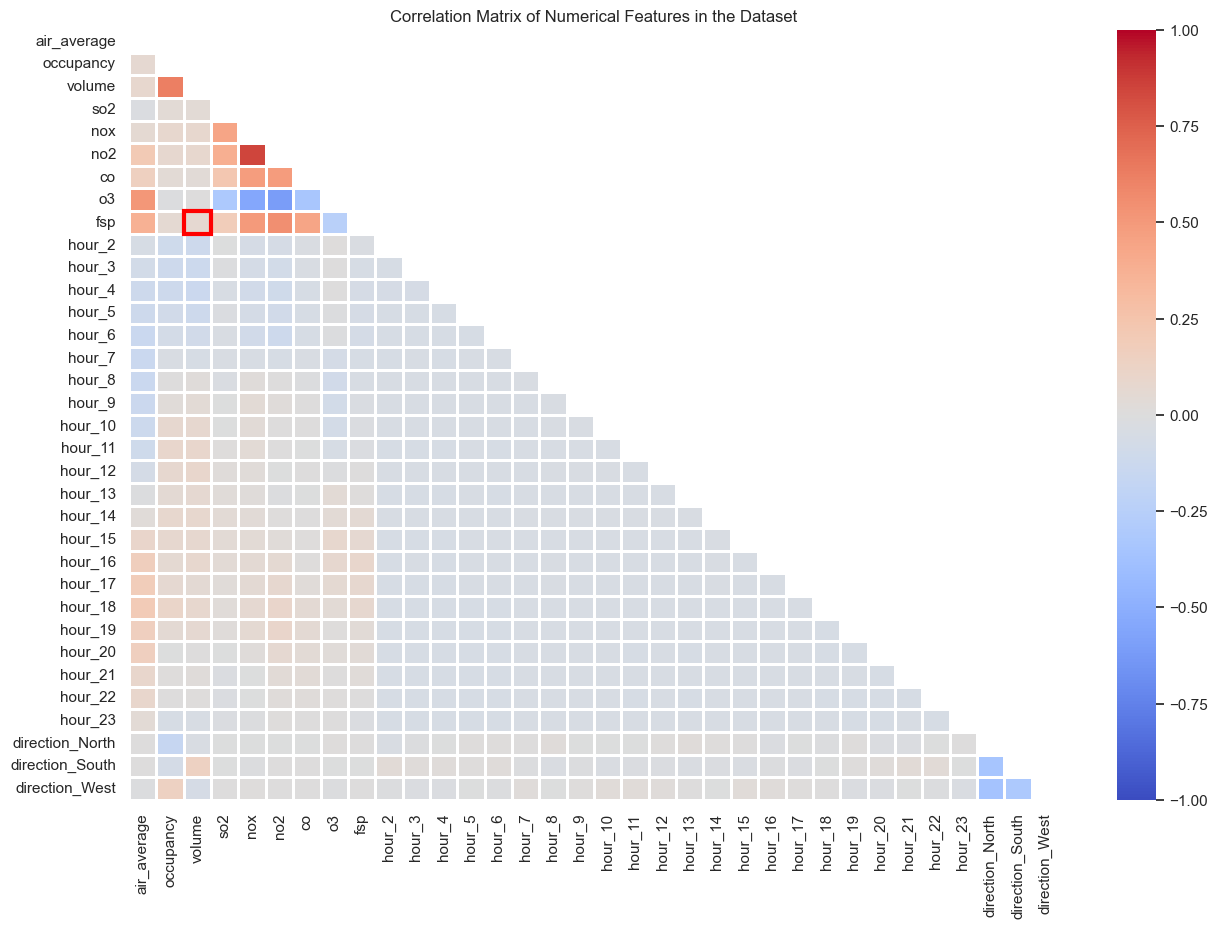

In [203]:
X = full_hk_traffic_air_df.drop(['speed','std_dev'], axis=1)

y = full_hk_traffic_air_df['air_average']
X = pd.get_dummies(X, 
                   columns=['hour', 'direction'], 
                   drop_first=True, dtype='int')

X_numerical_columns = X.select_dtypes(include=['float64', 'int64', 'int32']).columns
correlation_matrix = X[X_numerical_columns].corr()
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

plt.figure(figsize=(15, 10))
ax = sns.heatmap(correlation_matrix, mask=mask, annot=False, cmap='coolwarm', linewidths=0.9, vmin=-1, vmax=1)
plt.title("Correlation Matrix of Numerical Features in the Dataset")

row = correlation_matrix.columns.get_loc('fsp')  
col = correlation_matrix.columns.get_loc('volume') 

# highlight the correlation result
ax.add_patch(plt.Rectangle((col, row), 1, 1, fill=False, edgecolor='red', lw=3))
plt.show()


#### 5.4.3 Random Forest Estimation

In [204]:
X = X.drop(['lane_id','detector_id','valid'], axis=1)
X = pd.get_dummies(X, drop_first=True)
X.dtypes

date                         datetime64[ns]
air_average                         float64
occupancy                             int64
volume                                int64
so2                                 float64
nox                                 float64
no2                                 float64
co                                  float64
o3                                  float64
fsp                                 float64
hour_2                                int64
hour_3                                int64
hour_4                                int64
hour_5                                int64
hour_6                                int64
hour_7                                int64
hour_8                                int64
hour_9                                int64
hour_10                               int64
hour_11                               int64
hour_12                               int64
hour_13                               int64
hour_14                         

In [205]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# prepare X, remove speed and date and 
X = full_hk_traffic_air_df.drop(['speed', 'date'], axis=1)
X = pd.get_dummies(X, drop_first=True)

# prepare Y to be volume
y = pd.to_numeric(full_hk_traffic_air_df['air_average'], errors='coerce').dropna()

# Align y to the index of X
y = y.loc[X.index]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# model to be used
model = RandomForestRegressor(random_state=22)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

# evaluate how far off the predictions are from the actual values
mse = mean_squared_error(y_test, y_pred)

# how much of the variance in traffic volume is explained by this model built
# close to 1 means highly predictive
r2 = r2_score(y_test, y_pred)
print(f'Mean Squared Error: {mse}, R² Score: {r2}')


Mean Squared Error: 7.869699082452712e-27, R² Score: 1.0


In [206]:
full_hk_traffic_air_df

,date,hour,air_average,detector_id,direction,lane_id,speed,occupancy,volume,std_dev,valid,station,so2,nox,no2,co,o3,fsp
0,2024-02-15,23,3.166667,AID20057,North,Fast Lane,50,0,0,0.0,Y,causeway bay,8.0,432.000000,97.0,105.00000,7.0,26.0
1,2024-02-15,23,3.166667,AID20057,North,Fast Lane,50,0,0,0.0,Y,central,6.0,285.000000,102.0,122.00000,4.0,23.0
2,2024-02-15,23,3.166667,AID20057,North,Fast Lane,50,0,0,0.0,Y,central & western,2.0,38.000000,35.0,59.06501,67.0,13.0
3,2024-02-15,23,3.166667,AID20057,North,Fast Lane,50,0,0,0.0,Y,eastern,2.0,63.984217,62.0,59.06501,43.0,15.0
4,2024-02-15,23,3.166667,AID20057,North,Fast Lane,50,0,0,0.0,Y,kwai chung,6.0,200.000000,96.0,59.06501,2.0,18.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
141241,2024-02-29,23,2.055556,AID20022,East,Fast Lane,50,2,0,0.0,Y,tap mun,1.0,11.000000,8.0,52.00000,41.0,1.0
141242,2024-02-29,23,2.055556,AID20022,East,Fast Lane,50,2,0,0.0,Y,tuen mun,3.0,35.000000,30.0,78.00000,18.0,11.0
141243,2024-02-29,23,2.055556,AID20022,East,Fast Lane,50,2,0,0.0,Y,tai po,2.0,16.000000,15.0,59.06501,38.0,3.0
141244,2024-02-29,23,2.055556,AID20022,East,Fast Lane,50,2,0,0.0,Y,tsuen wan,1.0,40.000000,28.0,78.00000,29.0,5.0


Mean Squared Error: 5.488329314835093


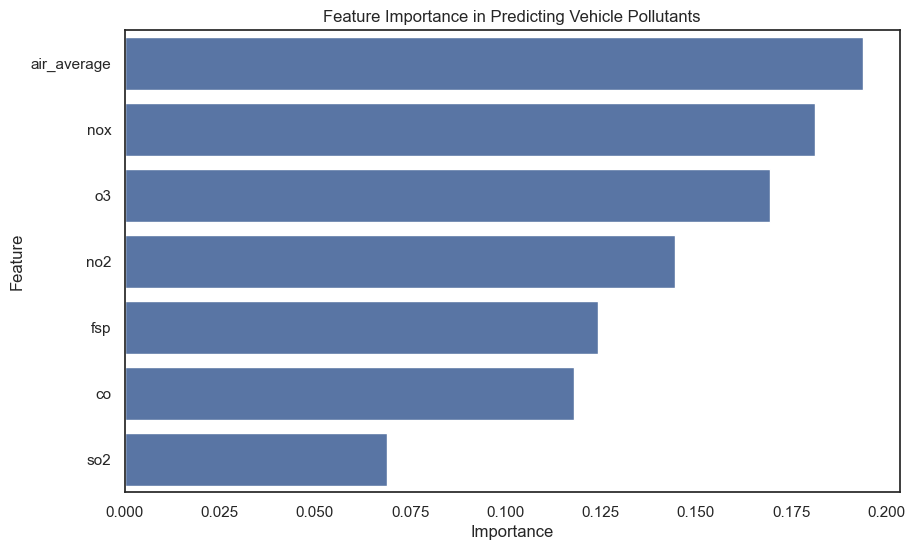

In [207]:
# Drop irrelevant columns for feature importance analysis
df_clean = full_hk_traffic_air_df.drop(columns=['date', 'detector_id', 'direction', 'lane_id', 'valid', 
                                                'station','std_dev','speed','valid','occupancy','hour'])

# Define features (X) and target (y)
X = df_clean.drop(columns=['volume'])
y = df_clean['volume']

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Initialize Random Forest Regressor
rf = RandomForestRegressor(n_estimators=100, random_state=20)

# Train the model
rf.fit(X_train, y_train)

# Make predictions and calculate error (optional)
y_pred = rf.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')

# Get feature importance
feature_importance = rf.feature_importances_

# Create a DataFrame for feature importance
features_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importance
})

# Sort the features by importance
features_df = features_df.sort_values(by='Importance', ascending=False)

# Plot the feature importance
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=features_df)
plt.title('Feature Importance in Predicting Vehicle Pollutants')
plt.show()

## 6. Conclusions and Recommendations

## 7. References

## 8. API URLs

### SG
##### Vehicle: https://data.gov.sg/datasets/d_2ecb009f1e1ec5a816a454944dec4022/view
##### PSI: https://data.gov.sg/datasets/d_fe37906a0182569d891506e815e819b7/view --> endpoint https://api-open.data.gov.sg/v2/real-time/api/psi?date={date}

### HK
##### Traffic: https://data.gov.hk/en-data/dataset/hk-td-tis_33-traffic-data-traffic-detectors-installed-at-smart-lampposts/resource/b914e460-1042-4a25-8940-7a4687ef254b
